In [64]:
import sys
import os

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..', 'wlcstat-master')))

import wlcstat.chromo

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..', 'stochastic-gene-conf-master')))

from stochastic_gene_conf import gene_conf
from stochastic_gene_conf import gene_analysis

figure_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'subfigures/'))

output_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'data/'))

import numpy as np
import numpy.matlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import pickle
import pandas as pd
from skimage import io
from skimage.measure import profile_line
from skimage.morphology import ball
from scipy import ndimage
from scipy.signal import find_peaks
from scipy.stats import norm
from scipy.stats import weibull_min
from scipy.stats import expon
from scipy.stats import iqr
import cc3d
import dijkstra3d

# ChromEMT Analysis

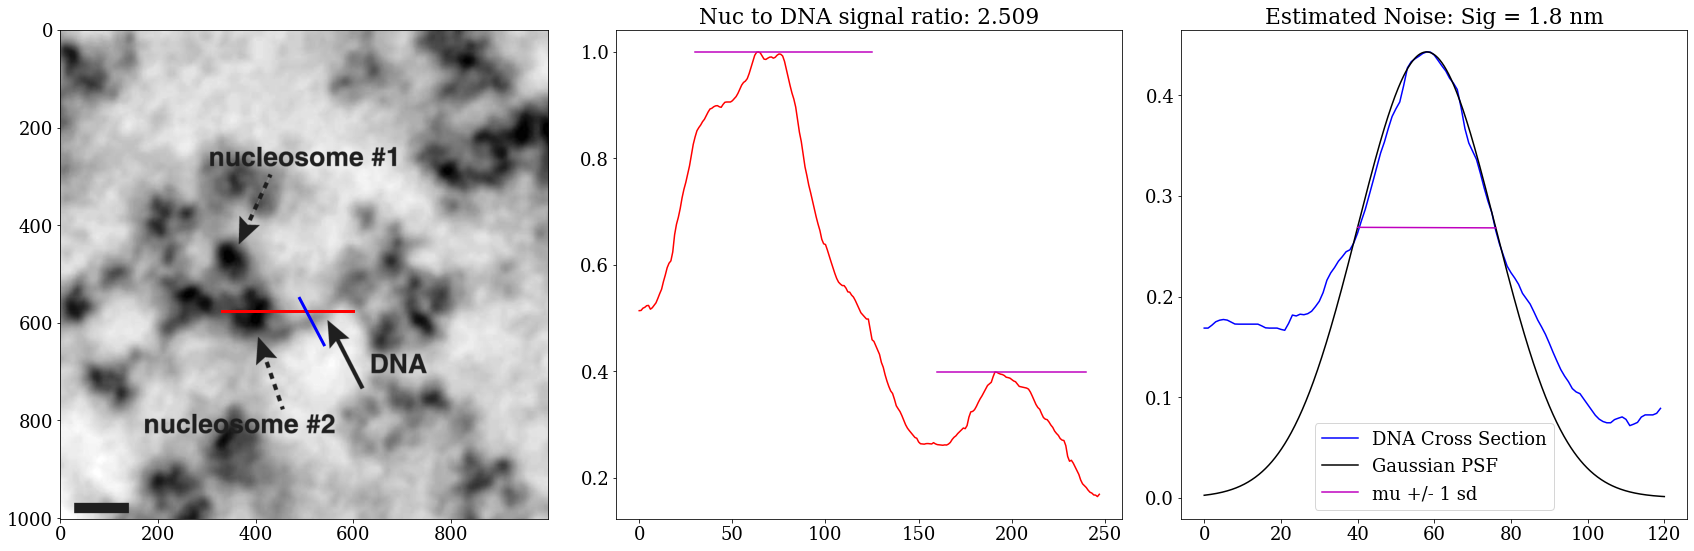

In [10]:
im1 = io.imread(figure_path + r"ChromEMTFig5C.png")
im1 = (im1-np.min(im1))/(np.max(im1)-np.min(im1))

plt.figure(figsize=(24,8))
font = {'family' : 'serif',
    'weight':'normal',
    'size': 18}
plt.rc('font', **font)


x1 = np.flip(np.array([330,600]))
y1 = np.flip(np.array([575,575]))
x2 = np.flip(np.array([490,540]))
y2 = np.flip(np.array([550,645]))


plt.subplot(1,3,1)
plt.imshow(im1,cmap='gray')
plt.plot(x1,y1,'r-',linewidth=3)
plt.plot(x2,y2,'b-',linewidth=3)

plt.subplot(1,3,2)
temp = profile_line(1-im1,x1,y1)
plt.plot(temp,'r-')
profile_peaks = find_peaks(temp,distance = 100)[0]
nuc_height = np.max(temp[profile_peaks])
dna_height = np.min(temp[profile_peaks])
plt.plot([30,125],nuc_height*np.ones(2),'m-')
plt.plot([160,240],dna_height*np.ones(2),'m-')
plt.title('Nuc to DNA signal ratio: '+str(np.round(nuc_height/dna_height,3)))


plt.subplot(1,3,3)
temp = profile_line(1-im1,x2,y2)[:-2]
plt.plot(temp,'b-',label = 'DNA Cross Section')
profile_peaks = find_peaks(temp,distance = 100)[0]
xtemp = np.linspace(0,120,1000)
mu = profile_peaks[0]
sig_real = 18
ytemp = norm.pdf(xtemp,loc=mu,scale=sig_real)
ytemp = np.max(temp)*ytemp/np.max(ytemp)
xtemp1 = xtemp[np.argmin(np.abs(xtemp-(mu-sig_real)))]
ytemp1 = ytemp[np.argmin(np.abs(xtemp-(mu-sig_real)))]
xtemp2 = xtemp[np.argmin(np.abs(xtemp-(mu+sig_real)))]
ytemp2 = ytemp[np.argmin(np.abs(xtemp-(mu+sig_real)))]



plt.plot(xtemp,ytemp,'k-',label='Gaussian PSF')
plt.plot([xtemp1,xtemp2],[ytemp1,ytemp2],'m-',label='mu +/- 1 sd')
plt.legend()
plt.title('Estimated Noise: Sig = '+str(np.round(sig_real*0.1,4))+' nm')

plt.draw()
plt.savefig(figure_path + r"chromemt_analysis.pdf", transparent=True)

plt.tight_layout()
plt.show()

In [11]:
im = io.imread(figure_path + r"oshea_em_data.tif")
im = (im-np.min(im))/(np.max(im)-np.min(im))
im = im[:,300:500,300:500]

thresh = 0.05

im_binary = np.copy(im)
im_binary[im <= thresh] = 0
im_binary[im >= thresh] = 1

In [15]:
delta_voxel = 1.64 # nm/voxel

output_img, N = cc3d.connected_components(1-im_binary, return_N=True)

print(N)

stats = cc3d.statistics(output_img)
centers = stats['centroids']

im_costs = 0*np.copy(im)

for i in range(np.shape(im)[0]):
    for j in range(np.shape(im)[1]):
        for k in range(np.shape(im)[2]):
            if output_img[i,j,k]!=1:
                        im_costs[i,j,k] = im[i,j,k]


costs = np.copy((im_costs-np.min(im_costs))/(np.max(im_costs)-np.min(im_costs)))

1410


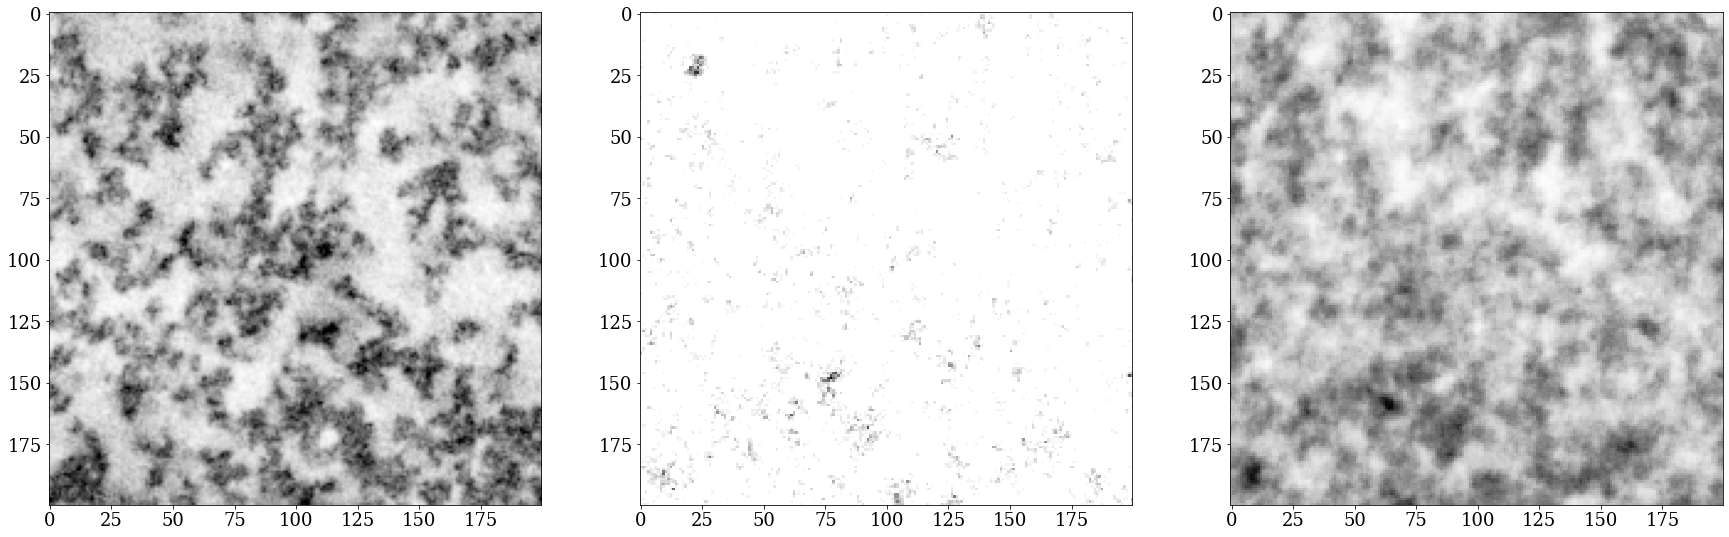

In [16]:
plt.figure(figsize=(30,10))
font = {'family' : 'serif',
    'weight':'normal',
    'size': 18}
plt.rc('font', **font)

plt.subplot(1,3,1)
plt.imshow(im[0,:,:],cmap='gray')

plt.subplot(1,3,2)
temp = np.sum(1-im_binary,axis=0)
plt.imshow(temp,cmap='Greys',  interpolation='nearest')

plt.subplot(1,3,3)
temp = np.sum(1-im_costs,axis=0)
plt.imshow(temp,cmap='Greys',  interpolation='nearest')

plt.draw()
plt.savefig(figure_path + r"em_binary.pdf", transparent=True)
plt.show()

In [19]:
distances = []
pairs = []

ix_array = np.arange(1,N+1)
np.random.shuffle(ix_array)

for counter in range(np.min([len(ix_array),1000])):
    ix = ix_array[counter]
    minD = 400
    pair = (np.zeros(3),np.zeros(3))
    visited = False
    if stats['voxel_counts'][ix] <= 10:
        idx = np.array([centers[ix,0].astype(int),centers[ix,1].astype(int),centers[ix,2].astype(int)])
        for jx in range(1,N):
            if stats['voxel_counts'][jx] <= 10:
                if jx != ix:
                    jdx = np.array([centers[jx,0].astype(int),centers[jx,1].astype(int),centers[jx,2].astype(int)])
                    if (np.linalg.norm(idx-jdx) < minD):
                        boolval = True
                        for k in range(len(pairs)):
                            if (np.linalg.norm(pairs[k][0]-idx)*
                                np.linalg.norm(pairs[k][1]-jdx)<=1e-3) or (np.linalg.norm(pairs[k][1]-idx)*
                                                                           np.linalg.norm(pairs[k][0]-jdx)<=1e-3):
                                boolval = False
                        if boolval:
                            path = dijkstra3d.dijkstra(costs, idx, jdx)

                            if len(path) > 0:
                                
                                
                                cost_temp = 0
                                for px in range(len(path)-2):
                                    cost_temp += np.linalg.norm(np.array(path[px+1]).astype(int)-np.array(path[px]).astype(int))*delta_voxel/0.34
                                cost = cost_temp
                                
                                
                            if cost < minD:
                                visited = True
                                minD = cost
                                pair = (idx,jdx)
    if visited and (minD >= delta_voxel):
        minD = minD
        distances.append(minD)
        pairs.append(pair)
        print(minD,pair)
        
distances = np.array(distances)

6.821500712623164 (array([ 48, 185,  68]), array([ 47, 186,  66]))
23.53069673858174 (array([31, 50,  0]), array([31, 53,  4]))
21.997599438225617 (array([ 48, 109,  56]), array([ 52, 106,  54]))
6.821500712623164 (array([ 22,  24, 135]), array([ 20,  23, 135]))
13.178127424743995 (array([ 54,  64, 172]), array([ 52,  66, 171]))
58.70642360155135 (array([48, 70, 60]), array([55, 75, 54]))
13.643001425246329 (array([ 15, 179,  23]), array([ 16, 178,  26]))
65.06305031367216 (array([ 33, 137,  80]), array([ 35, 146,  78]))
19.99962813736716 (array([50, 22, 12]), array([46, 20,  9]))
15.176098725602452 (array([ 15, 183, 148]), array([ 12, 182, 146]))
19.99962813736716 (array([27, 55,  3]), array([27, 59,  5]))
26.35625484948799 (array([ 45, 110,  18]), array([ 42, 110,  22]))
35.17572686296961 (array([ 30, 168, 125]), array([ 36, 173, 124]))
8.354598012979288 (array([ 64, 151, 126]), array([ 66, 152, 127]))
4.823529411764706 (array([ 29,   8, 100]), array([31,  7, 99]))
6.821500712623164 

In [21]:
with open(output_path+ r"EM_Links.pkl", 'wb') as file:
    pickle.dump(distances, file)

In [76]:
with open(output_path+ r"EM_Links.pkl", 'rb') as file:
    distances = pickle.load(file)

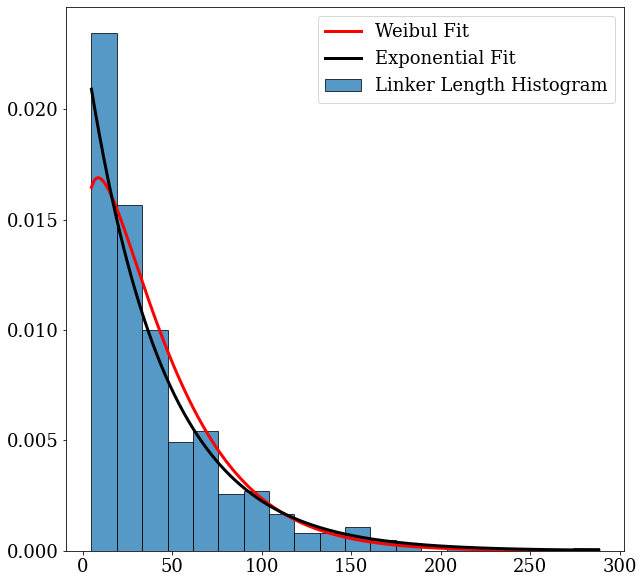

In [77]:
c = weibull_min.fit(np.array(distances),floc=0)
xtemp = np.linspace(np.min(np.array(distances)),np.max(np.array(distances)),1000);
ytemp = weibull_min.pdf(xtemp,c[0], c[1],c[2])
ytemp_poisson = expon.pdf(xtemp,loc=0,scale=np.mean(distances))

plt.figure(figsize=(10,10))
font = {'family' : 'serif',
    'weight':'normal',
    'size': 18}
plt.rc('font', **font)

plt.plot(xtemp,ytemp,'r-',linewidth=3,label='Weibul Fit')
plt.plot(xtemp,ytemp_poisson,'k-',linewidth=3,label='Exponential Fit')
plt.hist(np.array(distances),20,edgecolor='k',density=True,alpha=0.75,label='Linker Length Histogram')
# plt.xlim([0,90])
plt.legend()
plt.draw()
plt.savefig(figure_path + r"em_pdf.pdf", transparent=True)
plt.show()

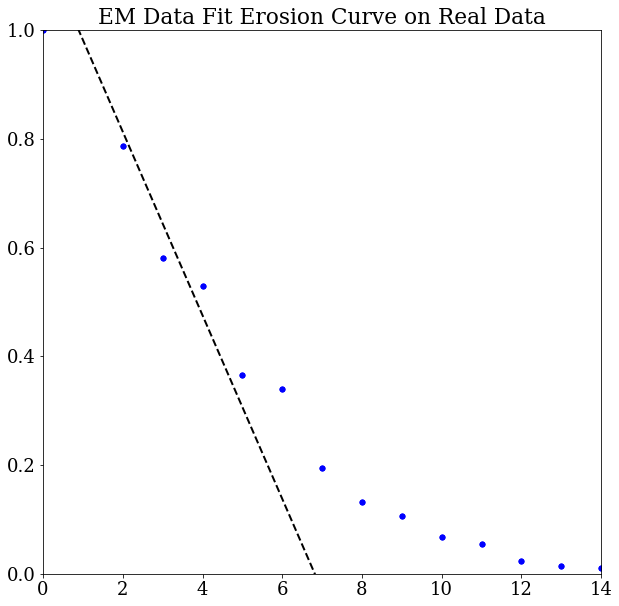

In [78]:
rho = np.arange(0,15,1)
rhomat = np.zeros(len(rho))

thresh = 0.5

delta_voxel = 1.64



im_binary_2 = np.copy(im)
im_binary_2[im <= thresh] = 0
im_binary_2[im >= thresh] = 1

for rx in range(len(rho)):
    rhomat[rx] = np.sum(ndimage.binary_erosion(im_binary_2,ball(np.round(2*rho[rx]/delta_voxel)/2)))/(np.sum(im_binary_2))
    
plt.figure(figsize=(10,10))
font = {'family' : 'serif',
    'weight':'normal',
    'size': 18}
plt.rc('font', **font)

coef = np.polyfit(rho[0:4],rhomat[0:4],1)
poly1d_fn = np.poly1d(coef)
plt.plot(rho,rhomat,'b.',markersize=10)
plt.plot(np.linspace(0,10,1000),poly1d_fn(np.linspace(0,10,1000)),'k--',linewidth=2)
plt.xlim([rho[0],rho[-1]])
plt.ylim([0,1])
plt.plot(rho,rhomat,'b.',markersize=10)
plt.title('EM Data Fit Erosion Curve on Real Data')

plt.draw()
plt.savefig(figure_path + r"em_erosion.pdf", transparent=True)
plt.show()

In [79]:
packed_lambda = c[2]
packed_k = c[0]

packed_link = np.round(np.mean(np.array(distances)))

seurat_file = r"C:\Users\jcorr\Documents\Macrophage_Project\Spakowitz_Project_1\macrophage_IL6.xlsx"
biomart_file = r"C:\Users\jcorr\Documents\Macrophage_Project\Spakowitz_Project_1\biomart_ensembl_ID_table_hg19.xlsx"
nucleoatacr_path = r"D:\Polymer_Data"

exp_name = "NULL"
i_gene = 1
half_wrap = 73

num_pts = 401

location = np.arange(0,99999,1)
signal = 0*location
accessible_starts = np.array([location[0]])
accessible_ends = np.array([location[-1]])
Gene_end = 99999


cdf = gene_conf.create_cdf(location,signal)

nucs = gene_conf.sample_cdf_poisson(location,signal,cdf,accessible_starts,
                                            accessible_ends,half_wrap,packed_link)

links = gene_conf.create_links_sample(location,signal,nucs,half_wrap)

r, rdna1, rdna2, rn, un = wlcstat.chromo.gen_chromo_conf(links.astype(int),w_ins=half_wrap-1,w_outs=half_wrap)

rmean = np.mean(r,axis=0)
        
window = 300

coordinates_x = np.linspace(rmean[0]-0.5*window,rmean[0]+0.5*window,num_pts)
coordinates_y = np.linspace(rmean[1]-0.5*window,rmean[1]+0.5*window,num_pts)
coordinates_z = np.linspace(rmean[2]-0.5*window,rmean[2]+0.5*window,num_pts)

delta_voxel = np.mean(np.diff(coordinates_z))

img_3d = np.zeros([num_pts,num_pts,num_pts])
for i in range(len(r)):
    if ((r[i,0] >= coordinates_x[0] and r[i,0] <= coordinates_x[-1]) and (r[i,1] >= coordinates_y[0] and r[i,1] <= coordinates_y[-1]) and (r[i,2] >= coordinates_z[0] and r[i,2] <= coordinates_z[-1])):
        img_3d[np.argmin(np.abs(r[i,0]-coordinates_x)),np.argmin(np.abs(r[i,1]-coordinates_y)),np.argmin(np.abs(r[i,2]-coordinates_z))] = 1
img_nucs = np.zeros([num_pts,num_pts,num_pts])
for i in range(len(rn)):
    if ((rn[i,0] >= coordinates_x[0] and rn[i,0] <= coordinates_x[-1]) and (rn[i,1] >= coordinates_y[0] and rn[i,1] <= coordinates_y[-1]) and (rn[i,2] >= coordinates_z[0] and rn[i,2] <= coordinates_z[-1])):
        img_nucs[np.argmin(np.abs(rn[i,0]-coordinates_x)),np.argmin(np.abs(rn[i,1]-coordinates_y)),np.argmin(np.abs(rn[i,2]-coordinates_z))] = 1

img_3d = img_3d + img_nucs

img_3d_closed= ndimage.gaussian_filter(img_3d-img_nucs,sigma=1.25/(1.5*delta_voxel)) + ndimage.gaussian_filter(img_nucs,sigma=5.5/(1.5*delta_voxel))

voxels = img_3d_closed.ravel()
voxels = voxels[voxels>0]
thresh = np.quantile(voxels,0.75)

img_3d_binary = 1.0*(img_3d_closed > thresh)

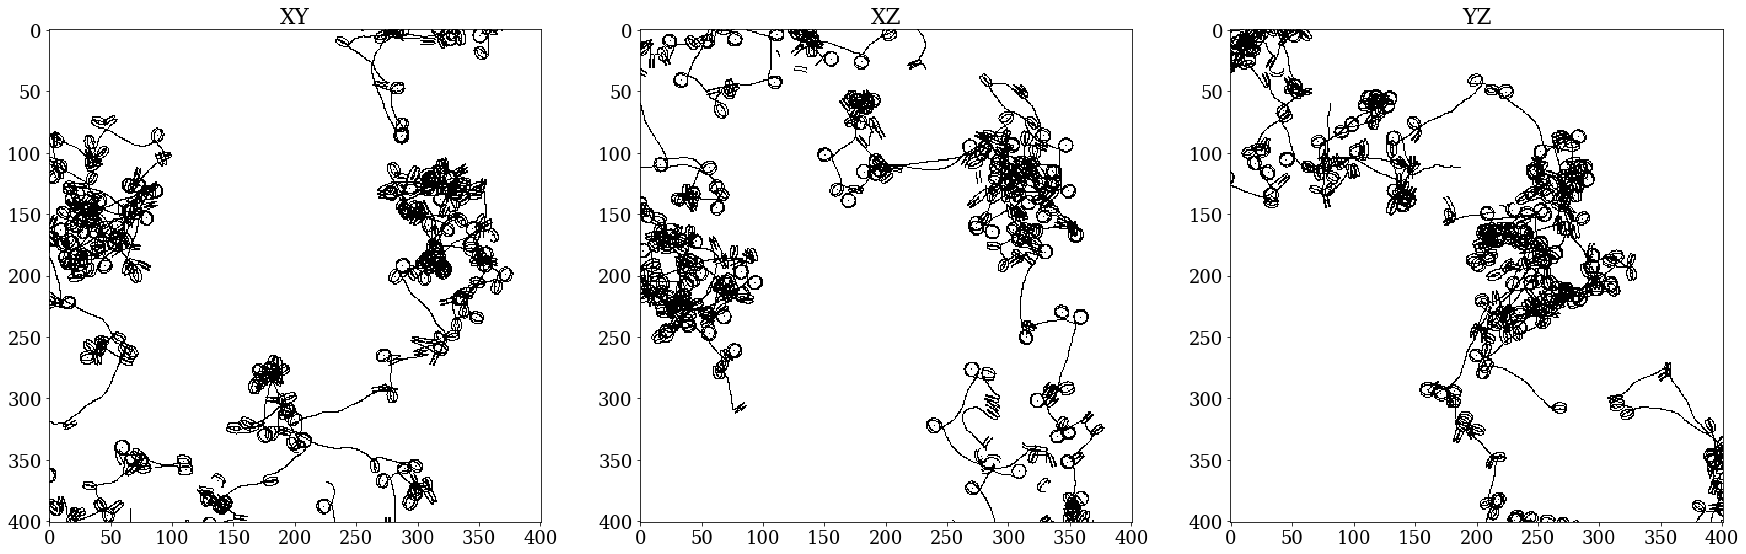

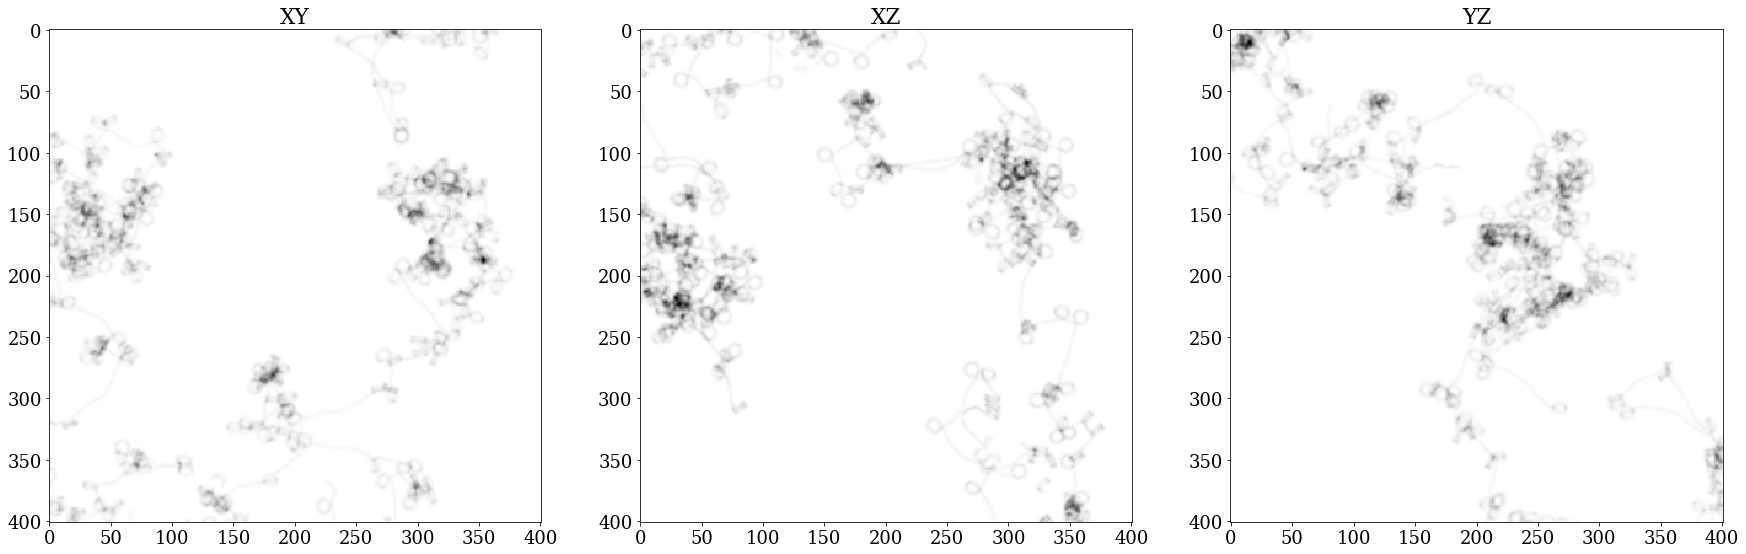

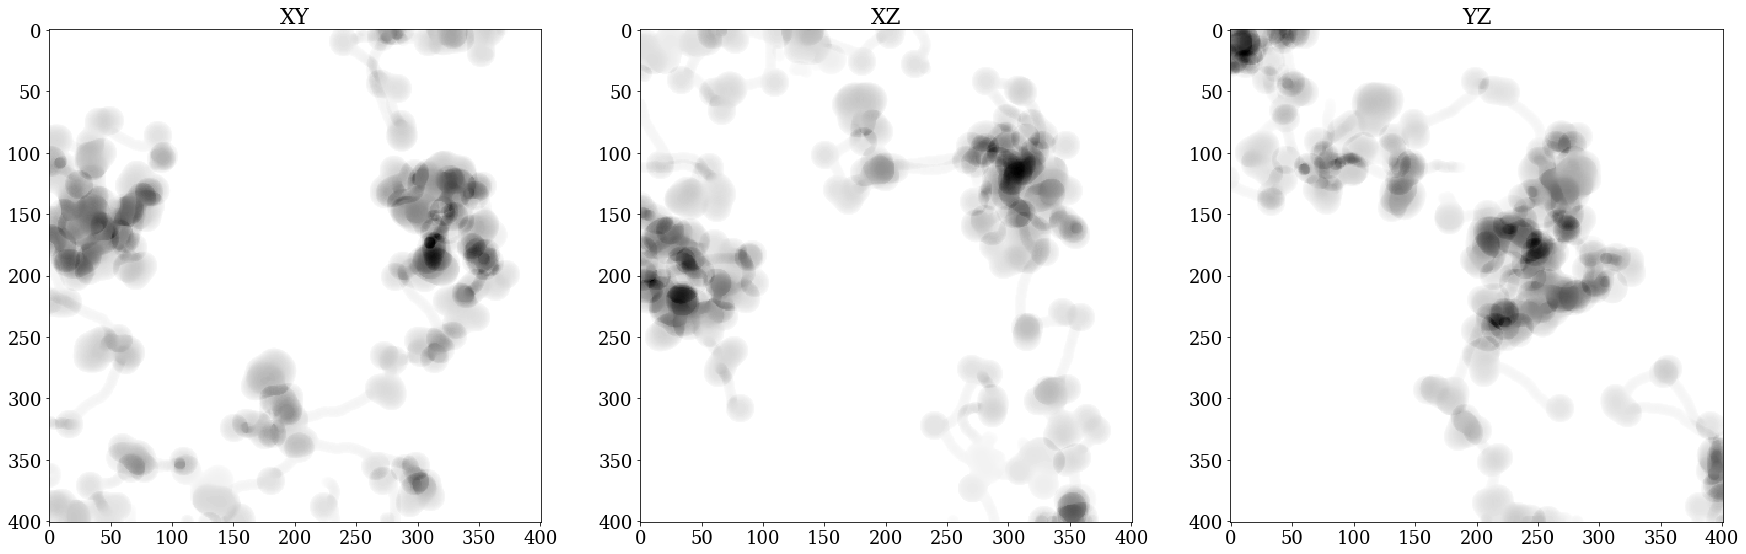

In [80]:
plt.figure(figsize=(30,10))
font = {'family' : 'serif',
    'weight':'normal',
    'size': 18}
plt.rc('font', **font)

plt.subplot(1,3,1)
temp = np.sum(img_3d,axis=2)
temp[temp > 0] = 1
plt.imshow(np.flip(temp.T,axis=0),cmap='Greys',  interpolation='nearest')
plt.title('XY')

plt.subplot(1,3,2)
temp = np.sum(img_3d,axis=1)
temp[temp > 0] = 1
plt.imshow(np.flip(temp.T,axis=0),cmap='Greys',  interpolation='nearest')
plt.title('XZ')

plt.subplot(1,3,3)
temp = np.sum(img_3d,axis=0)
temp[temp > 0] = 1
plt.imshow(np.flip(temp.T,axis=0),cmap='Greys',  interpolation='nearest')
plt.title('YZ')

plt.draw()
plt.savefig(figure_path + r"poisson_conformation.pdf", transparent=True)
plt.show()



plt.figure(figsize=(30,10))
font = {'family' : 'serif',
    'weight':'normal',
    'size': 18}
plt.rc('font', **font)

plt.subplot(1,3,1)
temp = np.sum(img_3d_closed,axis=2)
plt.imshow(np.flip(temp.T,axis=0),cmap='Greys',  interpolation='nearest')
plt.title('XY')

plt.subplot(1,3,2)
temp = np.sum(img_3d_closed,axis=1)
plt.imshow(np.flip(temp.T,axis=0),cmap='Greys',  interpolation='nearest')
plt.title('XZ')

plt.subplot(1,3,3)
temp = np.sum(img_3d_closed,axis=0)
plt.imshow(np.flip(temp.T,axis=0),cmap='Greys',  interpolation='nearest')
plt.title('YZ')

plt.show()



plt.figure(figsize=(30,10))
font = {'family' : 'serif',
    'weight':'normal',
    'size': 18}
plt.rc('font', **font)

plt.subplot(1,3,1)
temp = np.sum(img_3d_binary,axis=2)
plt.imshow(np.flip(temp.T,axis=0),cmap='Greys',  interpolation='nearest')
plt.title('XY')

plt.subplot(1,3,2)
temp = np.sum(img_3d_binary,axis=1)
plt.imshow(np.flip(temp.T,axis=0),cmap='Greys',  interpolation='nearest')
plt.title('XZ')

plt.subplot(1,3,3)
temp = np.sum(img_3d_binary,axis=0)
plt.imshow(np.flip(temp.T,axis=0),cmap='Greys',  interpolation='nearest')
plt.title('YZ')

plt.show()

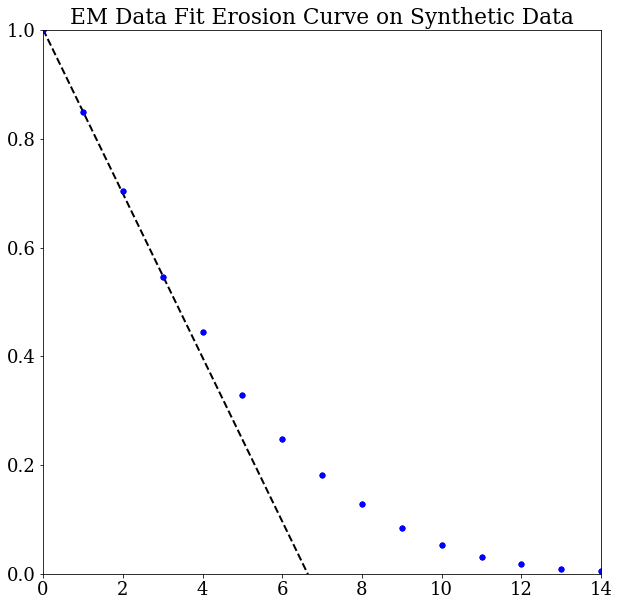

In [81]:
rho = np.arange(0,15,1)
rhomat = np.zeros(len(rho))

delta_voxel = 1

for rx in range(len(rho)):
    rhomat[rx] = np.sum(ndimage.binary_erosion(img_3d_binary,ball(np.round(2*rho[rx]/delta_voxel)/2)))/(np.sum(img_3d_binary))

plt.figure(figsize=(10,10))
font = {'family' : 'serif',
    'weight':'normal',
    'size': 18}
plt.rc('font', **font)

coef = np.polyfit(rho[0:4],rhomat[0:4],1)
poly1d_fn = np.poly1d(coef)
plt.plot(rho,rhomat,'b.',markersize=10)
plt.plot(np.linspace(0,10,1000),poly1d_fn(np.linspace(0,10,1000)),'k--',linewidth=2)
plt.xlim([rho[0],rho[-1]])
plt.ylim([0,1])
plt.plot(rho,rhomat,'b.',markersize=10)
plt.title('EM Data Fit Erosion Curve on Synthetic Data')

plt.draw()
plt.savefig(figure_path + r"synth_erosion.pdf", transparent=True)
plt.show()

# Synthetic EM Analysis

In [36]:
method = 'uniform'

M = 100

packed_link = 30
packed_sig = 20

half_wrap = 73

num_pts = 101
window = 100

thresh = 0.5

noise_vec = np.sort(np.append(np.linspace(0.0,4.0,15),sig_real*0.1))
nuc_ratio = nuc_height/dna_height

L = 1999

location = np.arange(0,L,1)
signal = 0*location
accessible_starts = np.array([location[0]])
accessible_ends = np.array([location[-1]])
Gene_end = L

cdf = gene_conf.create_cdf(location,signal)

img_3d = np.zeros([M,num_pts,num_pts,num_pts])
img_nucs = np.zeros([M,num_pts,num_pts,num_pts])

img_3d_noise = np.zeros([len(noise_vec),M,num_pts,num_pts,num_pts])
img_3d_closed = np.zeros([len(noise_vec),M,num_pts,num_pts,num_pts])
img_3d_binary = np.zeros([len(noise_vec),M,num_pts,num_pts,num_pts])

links_M = []
links_trim = []

for m in range(M):
    
    if method == 'poisson':
        nucs = gene_conf.sample_cdf_poisson(location,signal,cdf,accessible_starts,
                                                    accessible_ends,half_wrap,packed_link)
    if method == 'uniform':
        nucs = gene_conf.sample_cdf_uniform(location,signal,cdf,accessible_starts,
                                                    accessible_ends,half_wrap,packed_link,packed_sig)

    links = gene_conf.create_links_sample(location,signal,nucs,half_wrap)
    links_M = np.append(links_M,links)
    links_trim = np.append(links_trim,links[1:-1])

    r, rdna1, rdna2, rn, un = wlcstat.chromo.gen_chromo_conf(links.astype(int),w_ins=half_wrap-1,w_outs=half_wrap)
    r = r[3*half_wrap:-3*half_wrap,0:]

    rmean = np.mean(r,axis=0)

    coordinates_x = np.linspace(rmean[0]-0.5*window,rmean[0]+0.5*window,num_pts)
    coordinates_y = np.linspace(rmean[1]-0.5*window,rmean[1]+0.5*window,num_pts)
    coordinates_z = np.linspace(rmean[2]-0.5*window,rmean[2]+0.5*window,num_pts)

    delta_voxel = np.mean(np.diff(coordinates_z))


    for i in range(len(r)):
        if ((r[i,0] >= coordinates_x[0] and r[i,0] <= coordinates_x[-1]) and (r[i,1] >= coordinates_y[0] and r[i,1] <= coordinates_y[-1]) and (r[i,2] >= coordinates_z[0] and r[i,2] <= coordinates_z[-1])):
            img_3d[m,np.argmin(np.abs(r[i,0]-coordinates_x)),np.argmin(np.abs(r[i,1]-coordinates_y)),np.argmin(np.abs(r[i,2]-coordinates_z))] = 1#np.random.beta(5,2,1)

    img_3d[m,:,:,:] = ndimage.binary_dilation(img_3d[m,:,:,:],ball(np.round(2*1.25/delta_voxel)/2))


    for i in range(len(rn)):
        if ((rn[i,0] >= coordinates_x[0] and rn[i,0] <= coordinates_x[-1]) and (rn[i,1] >= coordinates_y[0] and rn[i,1] <= coordinates_y[-1]) and (rn[i,2] >= coordinates_z[0] and rn[i,2] <= coordinates_z[-1])):
            img_nucs[m,np.argmin(np.abs(rn[i,0]-coordinates_x)),np.argmin(np.abs(rn[i,1]-coordinates_y)),np.argmin(np.abs(rn[i,2]-coordinates_z))] = 1

    img_nucs[m,:,:,:] = ndimage.binary_dilation(img_nucs[m,:,:,:],ball(np.round(2*2.25/delta_voxel)/2))

    
    for s in range(len(noise_vec)):
    
        img_3d_noise[s,m,:,:,:] =  np.random.poisson((255*(ndimage.gaussian_filter(img_3d[m,:,:,:]+nuc_ratio*img_nucs[m,:,:,:],sigma=noise_vec[s]))).astype(int))/255
        img_3d_noise[s,m,:,:,:] = (img_3d_noise[s,m,:,:,:]-np.min(img_3d_noise[s,m,:,:,:]))/(np.max(img_3d_noise[s,m,:,:,:])-np.min(img_3d_noise[s,m,:,:,:]))

        img_3d_binary[s,m,:,:,:] = 1.0*(img_3d_noise[s,m,:,:,:]>thresh)

        for i in range(num_pts):
            for j in range(num_pts):
                for k in range(num_pts):
                    if img_3d_binary[s,m,i,j,k]!=1:
                        img_3d_closed[s,m,i,j,k] = img_3d_noise[s,m,i,j,k]

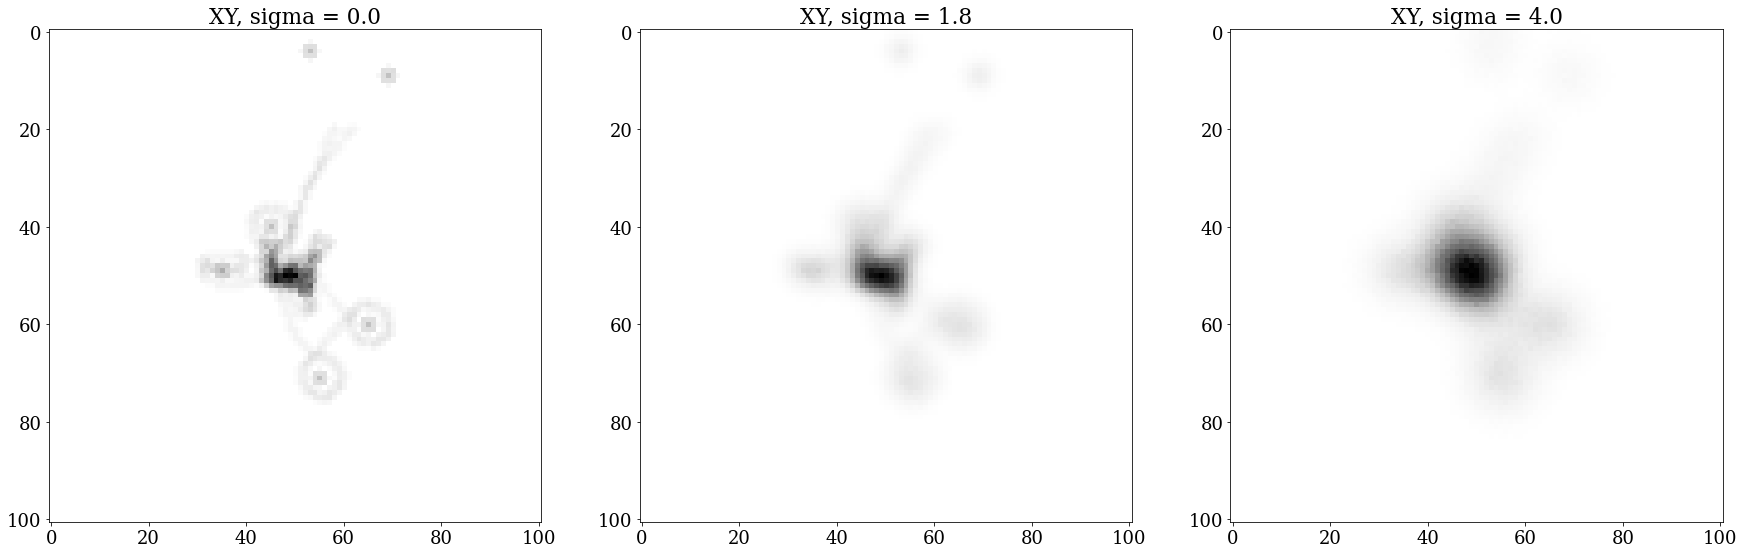

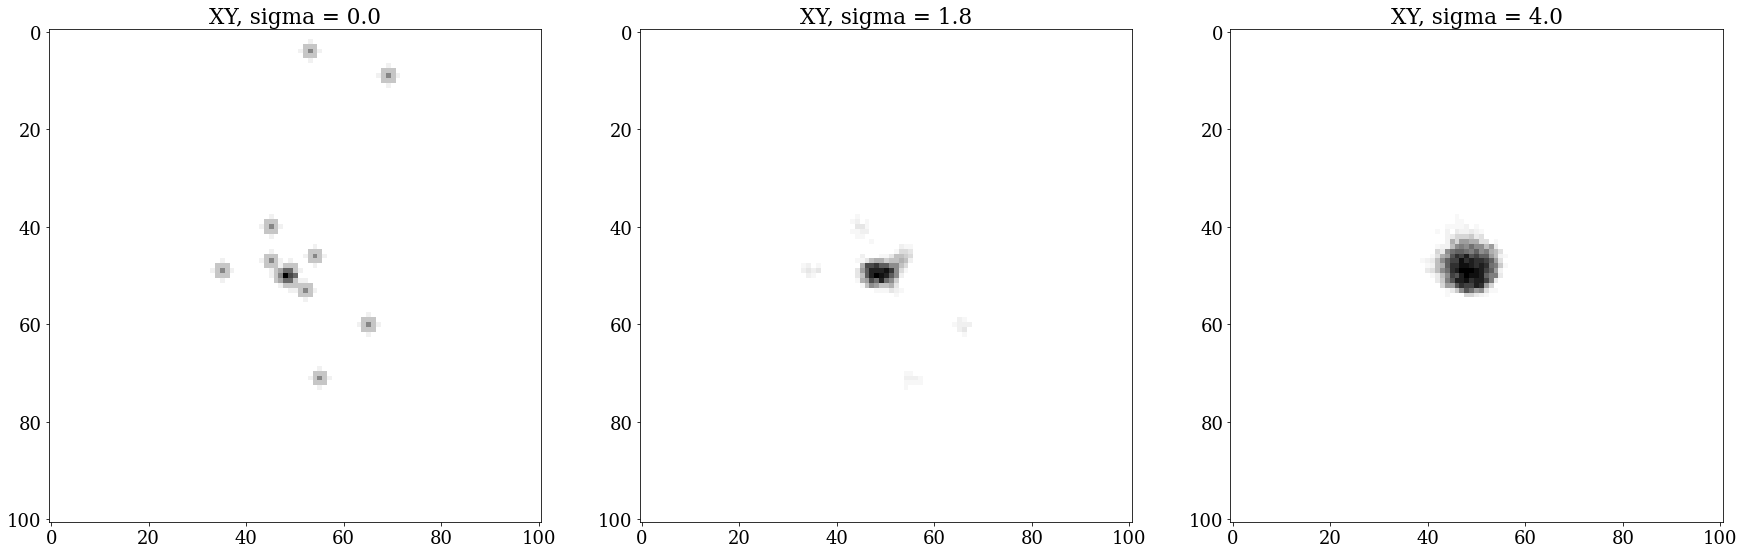

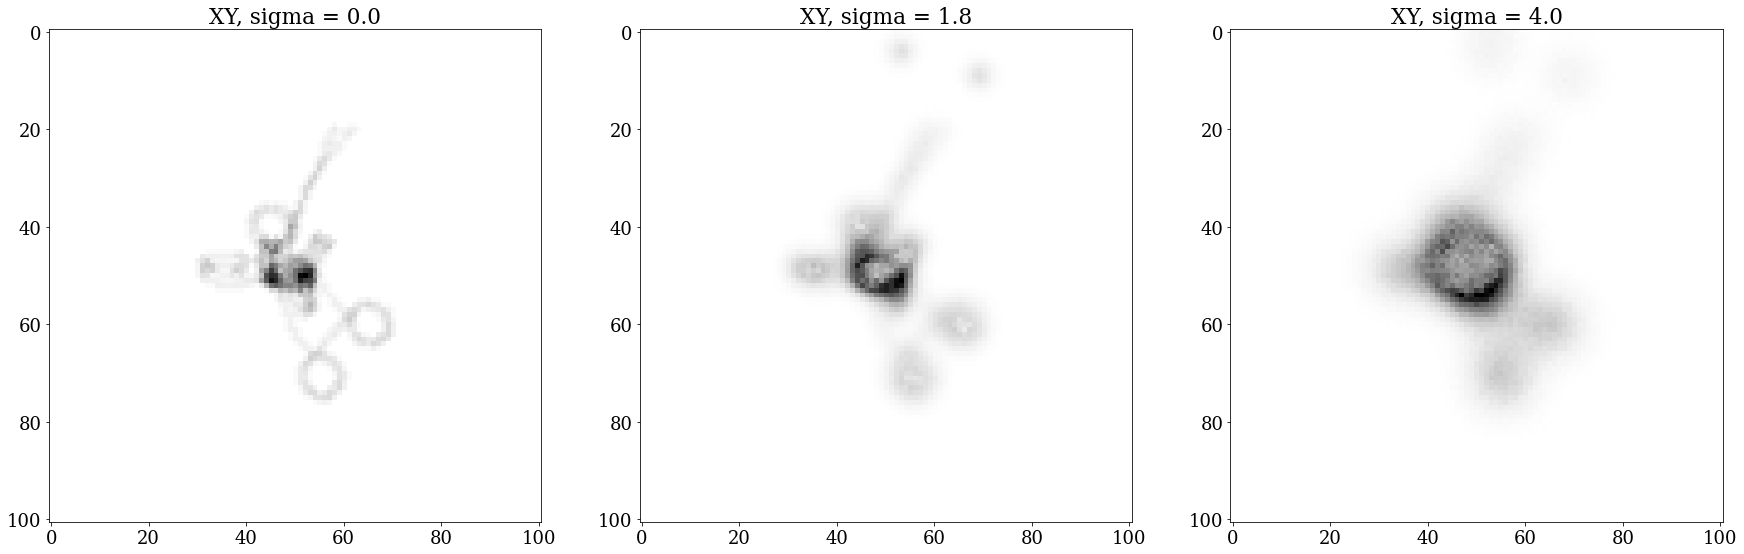

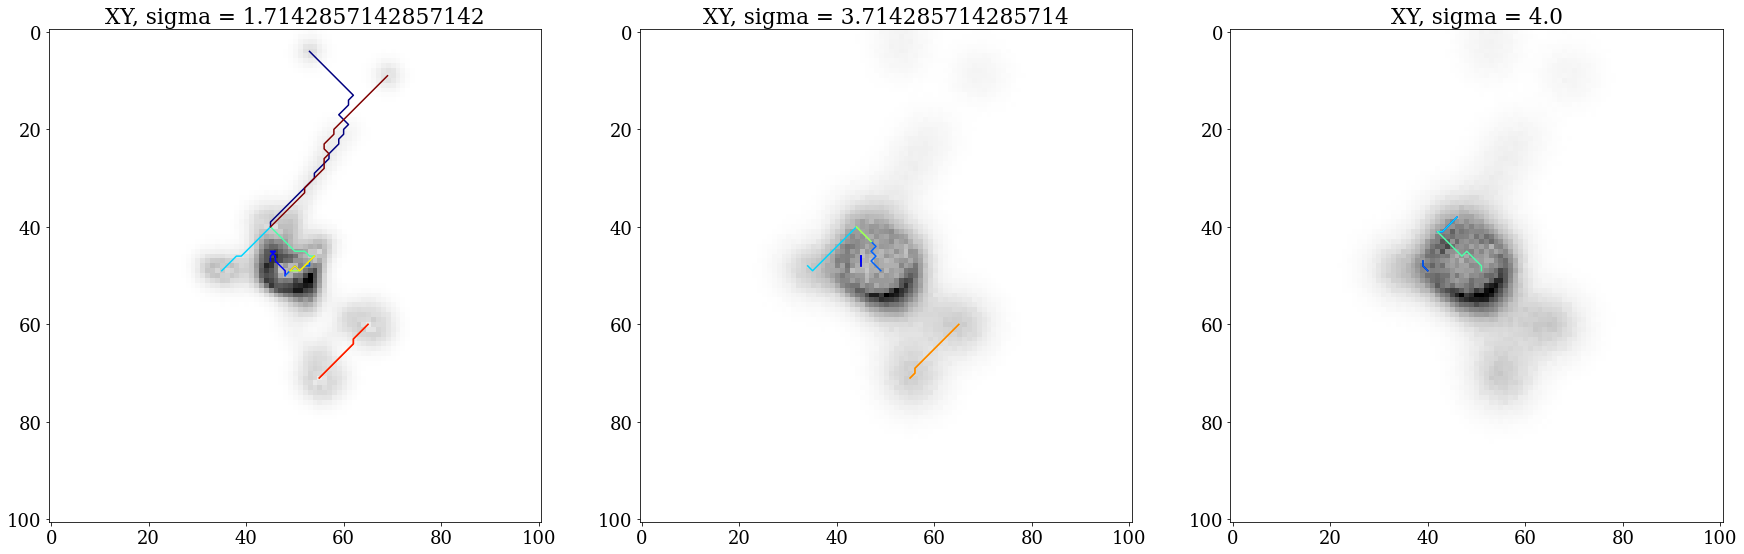

In [70]:
m = 0

plt.figure(figsize=(30,10))
font = {'family' : 'serif',
    'weight':'normal',
    'size': 18}
plt.rc('font', **font)

idx = 1
for s in [0,7,15]:
    plt.subplot(1,3,int(idx))
    idx+=1
    temp = np.sum(img_3d_noise[s,m,:,:,:],axis=0).T
    # temp[temp > 0] = 1
    # temp = temp+1
    plt.imshow(temp,cmap='Greys',  interpolation='nearest')
    plt.title('XY, sigma = '+str(noise_vec[s]))

    
plt.draw()
plt.savefig(figure_path + r"30_synth_em_raw.pdf", transparent=True)
    
plt.show()

plt.figure(figsize=(30,10))
font = {'family' : 'serif',
    'weight':'normal',
    'size': 18}
plt.rc('font', **font)

idx = 1
for s in [0,7,15]:
    plt.subplot(1,3,int(idx))
    idx+=1
    temp = np.sum(img_3d_binary[s,m,:,:,:],axis=0).T
    # temp[temp > 0] = 1
    # temp = temp+1
    plt.imshow(temp,cmap='Greys',  interpolation='nearest')
    plt.title('XY, sigma = '+str(noise_vec[s]))

plt.draw()
plt.savefig(figure_path + r"30_synth_em_nucs.pdf", transparent=True)
    
plt.show()

plt.figure(figsize=(30,10))
font = {'family' : 'serif',
    'weight':'normal',
    'size': 18}
plt.rc('font', **font)

idx = 1
for s in [0,7,15]:
    plt.subplot(1,3,int(idx))
    idx+=1
    temp = np.sum(img_3d_closed[s,m,:,:,:],axis=0).T
    # temp[temp > 0] = 1
    # temp = temp+1
    plt.imshow(temp,cmap='Greys',  interpolation='nearest')
    plt.title('XY, sigma = '+str(noise_vec[s]))
    

plt.draw()
plt.savefig(figure_path + r"30_synth_em_cost.pdf", transparent=True)

plt.show()

plt.figure(figsize=(30,10))
font = {'family' : 'serif',
    'weight':'normal',
    'size': 18}
plt.rc('font', **font)

cmap = plt.cm.get_cmap('jet', 10)

distances_dict = {'gt_reduced': links_trim,'gt' : links_M}
pairs_dict = {}

N_pairs = np.zeros([len(noise_vec),M])

plotidx = 0
for s in range(len(noise_vec)):
    distances_all = []
    pairs_all = []
    
    cx = 0
    if (s==0 or s==7 or s==15):
        plotidx+= 1
    plt.subplot(1,3,plotidx)
    temp = np.sum(img_3d_closed[s,0,:,:,:],axis=0).T
    plt.imshow(temp,cmap='Greys',  interpolation='nearest')
    plt.title('XY, sigma = '+str(noise_vec[s]))
    
    
    for m in range(M):

        output_img, N = cc3d.connected_components(img_3d_binary[s,m,:,:,:], return_N=True)

        stats = cc3d.statistics(output_img)
        centers = stats['centroids']

        costs = 1-img_3d_closed[s,m,:,:,:]

        distances = []
        pairs = []

        for ix in range(1,N):
            minD = 400
            pair = (np.zeros(3),np.zeros(3))
            visited = False
            if stats['voxel_counts'][ix] <= 1000:
                idx = np.array([centers[ix,0].astype(int),centers[ix,1].astype(int),centers[ix,2].astype(int)])
                for jx in range(1,N):
                    if stats['voxel_counts'][jx] <= 1000:
                        if jx != ix:
                            jdx = np.array([centers[jx,0].astype(int),centers[jx,1].astype(int),centers[jx,2].astype(int)])
                            if (np.linalg.norm(idx-jdx) < minD):
                                boolval = True
                                for k in range(len(pairs)):
                                    if (np.linalg.norm(pairs[k][0]-idx)*
                                        np.linalg.norm(pairs[k][1]-jdx)<=1e-3) or (np.linalg.norm(pairs[k][1]-idx)*
                                                                                   np.linalg.norm(pairs[k][0]-jdx)<=1e-3):
                                        boolval = False
                                if boolval:

                                    path = dijkstra3d.dijkstra(costs, idx, jdx)

                                    if len(path) > 0:

                                        cost_temp = 0
                                        for px in range(len(path)-2):
                                            cost_temp += np.linalg.norm(np.array(path[px+1]).astype(int)-np.array(path[px]).astype(int))*delta_voxel/0.34
                                        cost = cost_temp


                                    if cost < minD:
                                        visited = True
                                        minD = cost
                                        pair = (idx,jdx)
            if visited and (minD >= delta_voxel):
                minD = minD
                distances.append(np.max([minD-11,0]))
                
                if m == 0 and (s==0 or s==7 or s==15):
                
                    path = dijkstra3d.dijkstra(costs, pair[0], pair[1])
                    temp_path = np.zeros([3,len(path)])

                    for i in range(len(path)):
                        temp_path[0][i] = path[i][0]
                        temp_path[1][i] = path[i][1]
                        temp_path[2][i] = path[i][2]

                    plt.subplot(1,3,plotidx)

                    plt.plot(temp_path[1],temp_path[2],'-',color=cmap(cx))

                    cx += 1
                    if cx > 9:
                        cx = 0


        distances_all = np.append(distances_all,distances)
        pairs_all = np.append(pairs_all,pairs)
        N_pairs[s,m] = len(distances)
        
    distances_dict[s] = distances_all
    pairs_dict[s] = pairs_all

distances_df = pd.DataFrame({ key:pd.Series(value) for key, value in distances_dict.items() })
pairs_df = pd.DataFrame({ key:pd.Series(value) for key, value in pairs_dict.items() })

plt.draw()
plt.savefig(figure_path + r"30_synth_em_paths.pdf", transparent=True)

plt.show()

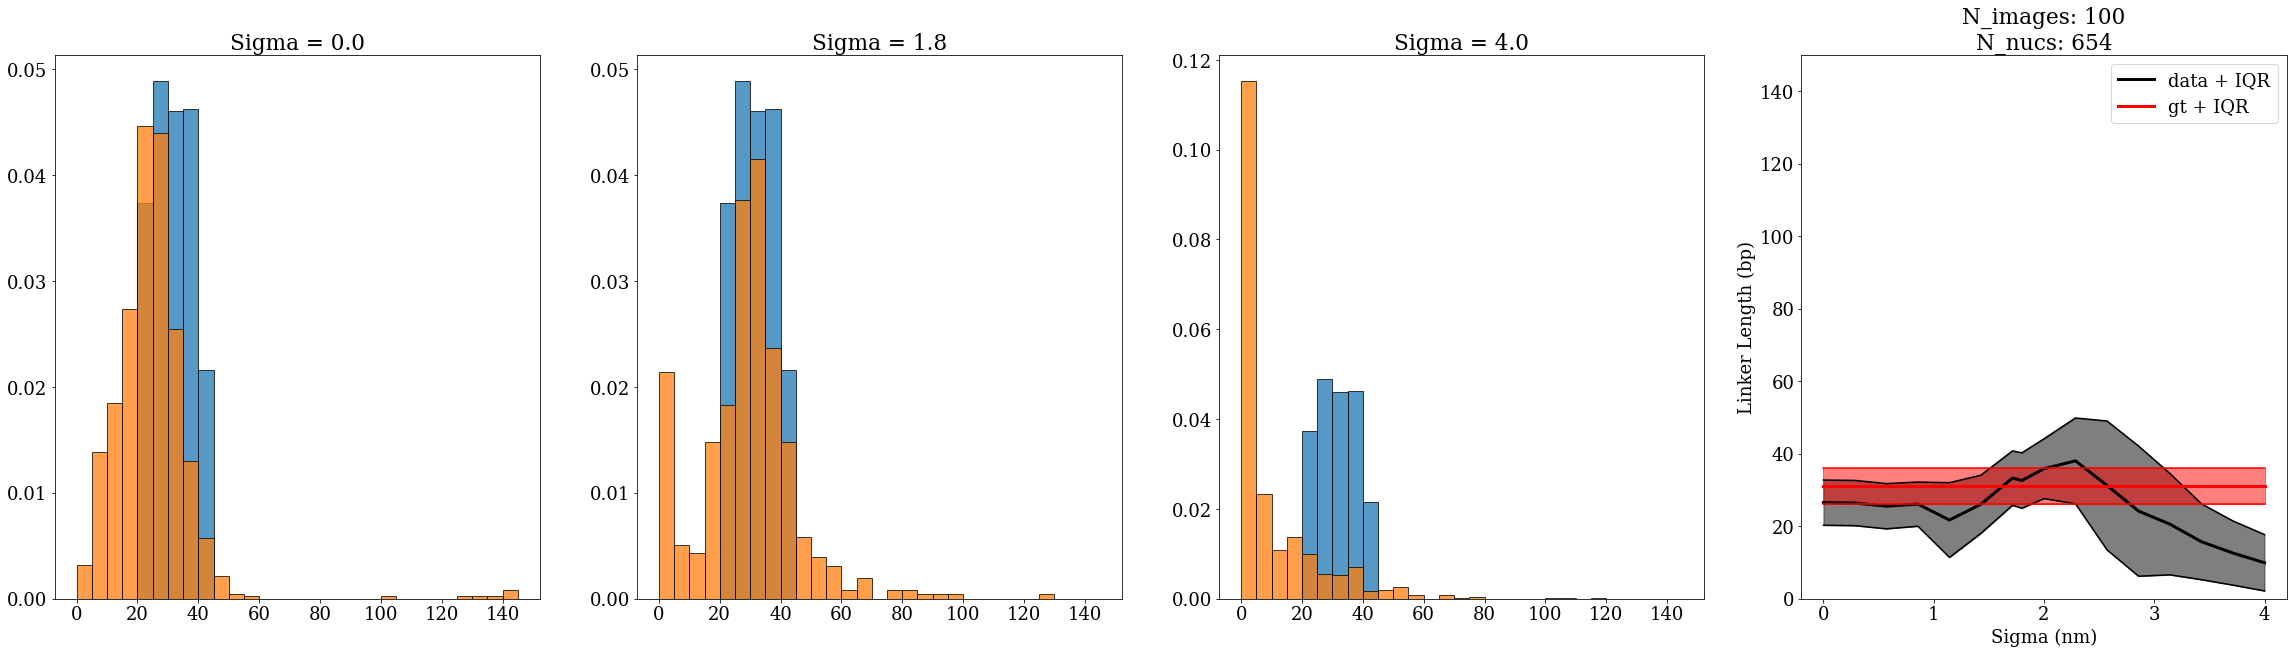

In [71]:
plt.figure(figsize=(40,10))
font = {'family' : 'serif',
    'weight':'normal',
    'size': 18}
plt.rc('font', **font)

plotidx = 1
for s in [0,7,15]:

    plt.subplot(1,4,plotidx)
    plotidx+=1
    plt.hist(links_M,density=True,edgecolor='k',alpha=0.75,label='GT Linker Lengths',bins=np.arange(0,150,5))
    plt.hist(np.array(distances_df[s])[~np.isnan(distances_df[s])],density=True,edgecolor='k',alpha=0.75,label='0.0 Noise Linker Lengths',bins=np.arange(0,150,5))
    # plt.xlim([30,100])
    plt.title('Sigma = ' + str(noise_vec[s]))
    
    
M_tot = 100

N_tot = np.sum(N_pairs[:,0:M_tot],axis=1).astype(int)

alg_means = np.zeros(len(noise_vec))
alg_std = np.zeros(len(noise_vec))

for s in range(len(noise_vec)):
    alg_means[s] = np.mean(np.array(distances_df[s][0:N_tot[s]])[~np.isnan(distances_df[s][0:N_tot[s]])])
    alg_std[s] = 0.5*iqr(np.array(distances_df[s][0:N_tot[s]])[~np.isnan(distances_df[s][0:N_tot[s]])])

gt_mean = np.ones(len(noise_vec))*np.mean(np.array(distances_df['gt_reduced'])[~np.isnan(distances_df['gt_reduced'])])
gt_std = np.ones(len(noise_vec))*0.5*iqr(np.array(distances_df['gt_reduced'])[~np.isnan(distances_df['gt_reduced'])])

plt.subplot(1,4,plotidx)
plt.plot(noise_vec,alg_means,'k-',linewidth=3, label='data + IQR')

plt.plot(noise_vec,alg_means-alg_std,'k-')
plt.plot(noise_vec,alg_means+alg_std,'k-')
plt.fill_between(noise_vec,alg_means-alg_std,
                 alg_means+alg_std,color='k',alpha=0.5)

plt.plot(noise_vec,gt_mean,'r-',linewidth=3,label =  'gt + IQR')

plt.plot(noise_vec,gt_mean-gt_std,'r-')
plt.plot(noise_vec,gt_mean+gt_std,'r-')
plt.fill_between(noise_vec,gt_mean-gt_std,
                 gt_mean+gt_std,color='r',alpha=0.5)


plt.ylim([0,150])
plt.legend()
plt.title('N_images: '+str(M_tot)+'\n'+'N_nucs: '+str(int(np.mean(N_tot))))
plt.xlabel('Sigma (nm)')
plt.ylabel('Linker Length (bp)')

plt.draw()
plt.savefig(figure_path + r"30_"+str(s)+r"_validation_dist.pdf", transparent=True)
plt.show()

In [82]:
method = 'uniform'

M = 100

packed_link = 60
packed_sig = 20

half_wrap = 73

num_pts = 101
window = 100

thresh = 0.5

noise_vec = np.sort(np.append(np.linspace(0.0,4.0,15),sig_real*0.1))
nuc_ratio = nuc_height/dna_height

L = 1999

location = np.arange(0,L,1)
signal = 0*location
accessible_starts = np.array([location[0]])
accessible_ends = np.array([location[-1]])
Gene_end = L

cdf = gene_conf.create_cdf(location,signal)

img_3d = np.zeros([M,num_pts,num_pts,num_pts])
img_nucs = np.zeros([M,num_pts,num_pts,num_pts])

img_3d_noise = np.zeros([len(noise_vec),M,num_pts,num_pts,num_pts])
img_3d_closed = np.zeros([len(noise_vec),M,num_pts,num_pts,num_pts])
img_3d_binary = np.zeros([len(noise_vec),M,num_pts,num_pts,num_pts])

links_M = []
links_trim = []

for m in range(M):
    
    if method == 'poisson':
        nucs = gene_conf.sample_cdf_poisson(location,signal,cdf,accessible_starts,
                                                    accessible_ends,half_wrap,packed_link)
    if method == 'uniform':
        nucs = gene_conf.sample_cdf_uniform(location,signal,cdf,accessible_starts,
                                                    accessible_ends,half_wrap,packed_link,packed_sig)

    links = gene_conf.create_links_sample(location,signal,nucs,half_wrap)
    links_M = np.append(links_M,links)
    links_trim = np.append(links_trim,links[1:-1])

    r, rdna1, rdna2, rn, un = wlcstat.chromo.gen_chromo_conf(links.astype(int),w_ins=half_wrap-1,w_outs=half_wrap)
    r = r[3*half_wrap:-3*half_wrap,0:]

    rmean = np.mean(r,axis=0)

    coordinates_x = np.linspace(rmean[0]-0.5*window,rmean[0]+0.5*window,num_pts)
    coordinates_y = np.linspace(rmean[1]-0.5*window,rmean[1]+0.5*window,num_pts)
    coordinates_z = np.linspace(rmean[2]-0.5*window,rmean[2]+0.5*window,num_pts)

    delta_voxel = np.mean(np.diff(coordinates_z))


    for i in range(len(r)):
        if ((r[i,0] >= coordinates_x[0] and r[i,0] <= coordinates_x[-1]) and (r[i,1] >= coordinates_y[0] and r[i,1] <= coordinates_y[-1]) and (r[i,2] >= coordinates_z[0] and r[i,2] <= coordinates_z[-1])):
            img_3d[m,np.argmin(np.abs(r[i,0]-coordinates_x)),np.argmin(np.abs(r[i,1]-coordinates_y)),np.argmin(np.abs(r[i,2]-coordinates_z))] = 1#np.random.beta(5,2,1)

    img_3d[m,:,:,:] = ndimage.binary_dilation(img_3d[m,:,:,:],ball(np.round(2*1.25/delta_voxel)/2))


    for i in range(len(rn)):
        if ((rn[i,0] >= coordinates_x[0] and rn[i,0] <= coordinates_x[-1]) and (rn[i,1] >= coordinates_y[0] and rn[i,1] <= coordinates_y[-1]) and (rn[i,2] >= coordinates_z[0] and rn[i,2] <= coordinates_z[-1])):
            img_nucs[m,np.argmin(np.abs(rn[i,0]-coordinates_x)),np.argmin(np.abs(rn[i,1]-coordinates_y)),np.argmin(np.abs(rn[i,2]-coordinates_z))] = 1

    img_nucs[m,:,:,:] = ndimage.binary_dilation(img_nucs[m,:,:,:],ball(np.round(2*2.25/delta_voxel)/2))

    
    for s in range(len(noise_vec)):
    
        img_3d_noise[s,m,:,:,:] =  np.random.poisson((255*(ndimage.gaussian_filter(img_3d[m,:,:,:]+nuc_ratio*img_nucs[m,:,:,:],sigma=noise_vec[s]))).astype(int))/255
        img_3d_noise[s,m,:,:,:] = (img_3d_noise[s,m,:,:,:]-np.min(img_3d_noise[s,m,:,:,:]))/(np.max(img_3d_noise[s,m,:,:,:])-np.min(img_3d_noise[s,m,:,:,:]))

        img_3d_binary[s,m,:,:,:] = 1.0*(img_3d_noise[s,m,:,:,:]>thresh)

        for i in range(num_pts):
            for j in range(num_pts):
                for k in range(num_pts):
                    if img_3d_binary[s,m,i,j,k]!=1:
                        img_3d_closed[s,m,i,j,k] = img_3d_noise[s,m,i,j,k]

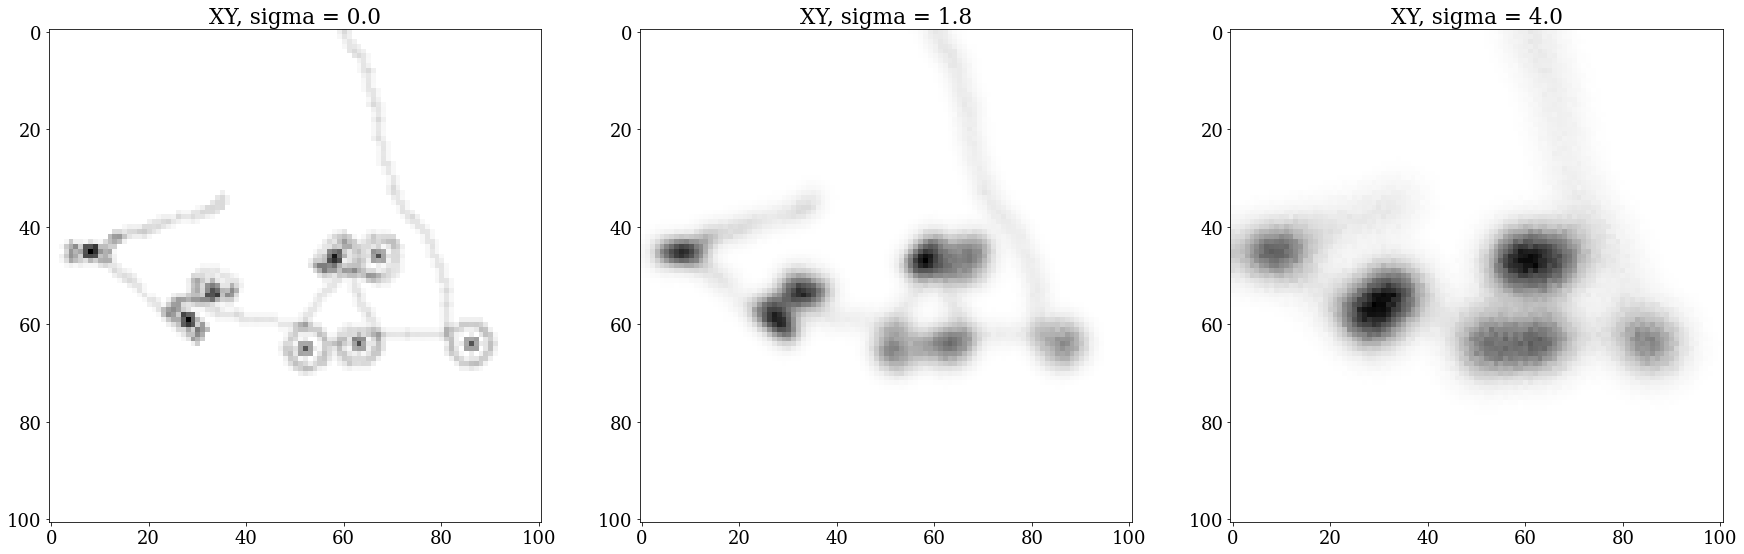

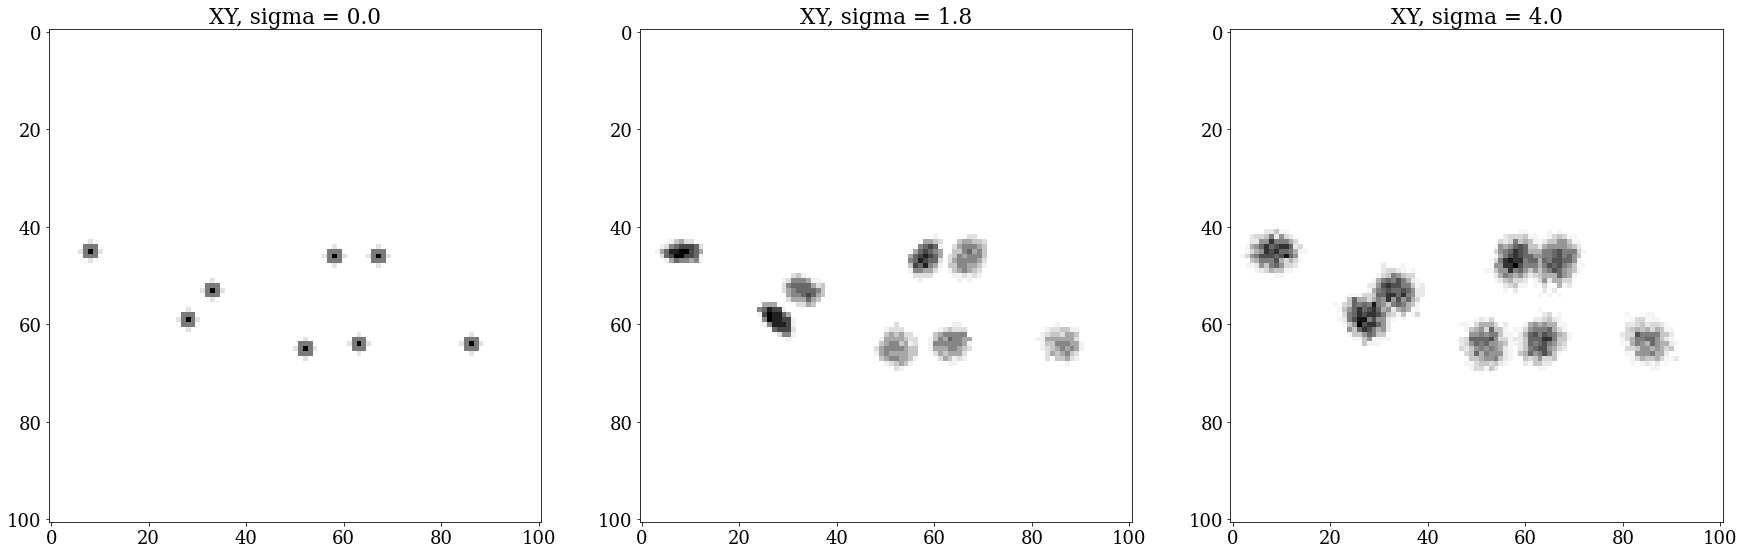

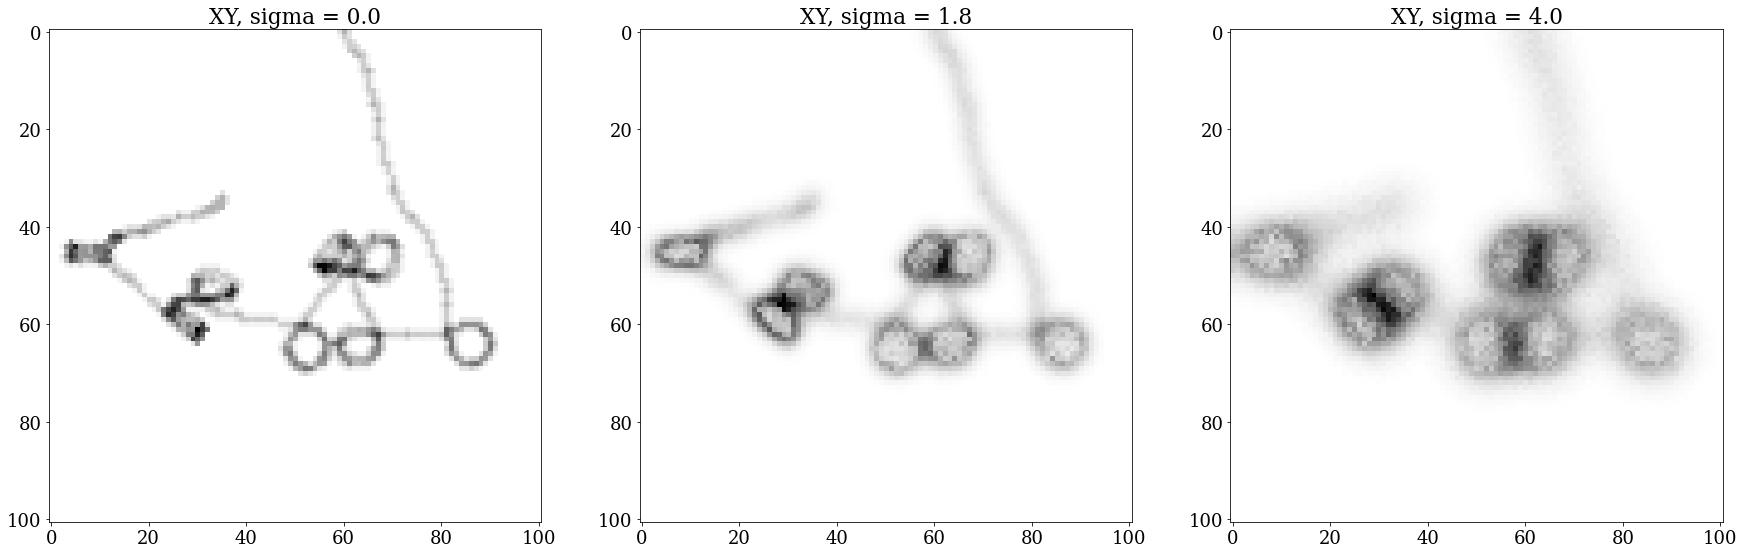

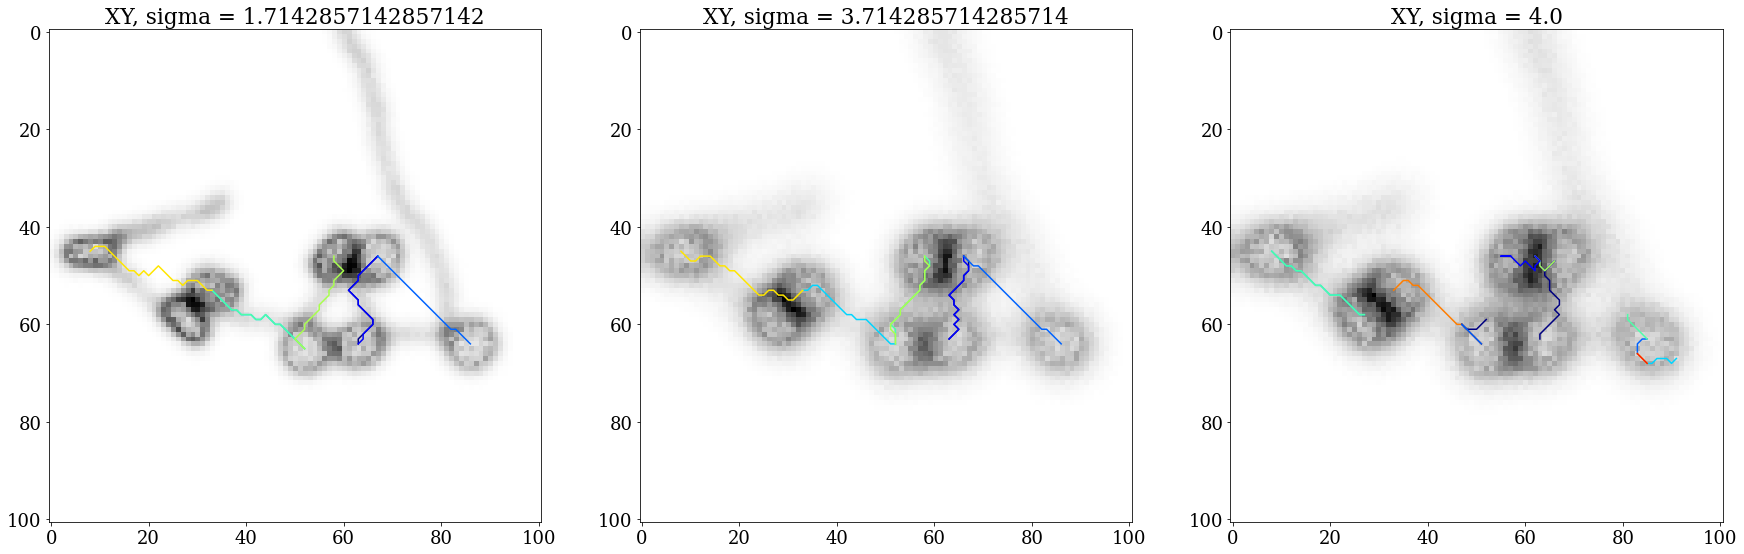

In [83]:
m = 0

plt.figure(figsize=(30,10))
font = {'family' : 'serif',
    'weight':'normal',
    'size': 18}
plt.rc('font', **font)

idx = 1
for s in [0,7,15]:
    plt.subplot(1,3,int(idx))
    idx+=1
    temp = np.sum(img_3d_noise[s,m,:,:,:],axis=0).T
    # temp[temp > 0] = 1
    # temp = temp+1
    plt.imshow(temp,cmap='Greys',  interpolation='nearest')
    plt.title('XY, sigma = '+str(noise_vec[s]))

    
plt.draw()
plt.savefig(figure_path + r"30_synth_em_raw.pdf", transparent=True)
    
plt.show()

plt.figure(figsize=(30,10))
font = {'family' : 'serif',
    'weight':'normal',
    'size': 18}
plt.rc('font', **font)

idx = 1
for s in [0,7,15]:
    plt.subplot(1,3,int(idx))
    idx+=1
    temp = np.sum(img_3d_binary[s,m,:,:,:],axis=0).T
    # temp[temp > 0] = 1
    # temp = temp+1
    plt.imshow(temp,cmap='Greys',  interpolation='nearest')
    plt.title('XY, sigma = '+str(noise_vec[s]))

plt.draw()
plt.savefig(figure_path + r"30_synth_em_nucs.pdf", transparent=True)
    
plt.show()

plt.figure(figsize=(30,10))
font = {'family' : 'serif',
    'weight':'normal',
    'size': 18}
plt.rc('font', **font)

idx = 1
for s in [0,7,15]:
    plt.subplot(1,3,int(idx))
    idx+=1
    temp = np.sum(img_3d_closed[s,m,:,:,:],axis=0).T
    # temp[temp > 0] = 1
    # temp = temp+1
    plt.imshow(temp,cmap='Greys',  interpolation='nearest')
    plt.title('XY, sigma = '+str(noise_vec[s]))
    

plt.draw()
plt.savefig(figure_path + r"30_synth_em_cost.pdf", transparent=True)

plt.show()

plt.figure(figsize=(30,10))
font = {'family' : 'serif',
    'weight':'normal',
    'size': 18}
plt.rc('font', **font)

cmap = plt.cm.get_cmap('jet', 10)

distances_dict = {'gt_reduced': links_trim,'gt' : links_M}
pairs_dict = {}

N_pairs = np.zeros([len(noise_vec),M])

plotidx = 0
for s in range(len(noise_vec)):
    distances_all = []
    pairs_all = []
    
    cx = 0
    if (s==0 or s==7 or s==15):
        plotidx+= 1
    plt.subplot(1,3,plotidx)
    temp = np.sum(img_3d_closed[s,0,:,:,:],axis=0).T
    plt.imshow(temp,cmap='Greys',  interpolation='nearest')
    plt.title('XY, sigma = '+str(noise_vec[s]))
    
    
    for m in range(M):

        output_img, N = cc3d.connected_components(img_3d_binary[s,m,:,:,:], return_N=True)

        stats = cc3d.statistics(output_img)
        centers = stats['centroids']

        costs = 1-img_3d_closed[s,m,:,:,:]

        distances = []
        pairs = []

        for ix in range(1,N):
            minD = 400
            pair = (np.zeros(3),np.zeros(3))
            visited = False
            if stats['voxel_counts'][ix] <= 1000:
                idx = np.array([centers[ix,0].astype(int),centers[ix,1].astype(int),centers[ix,2].astype(int)])
                for jx in range(1,N):
                    if stats['voxel_counts'][jx] <= 1000:
                        if jx != ix:
                            jdx = np.array([centers[jx,0].astype(int),centers[jx,1].astype(int),centers[jx,2].astype(int)])
                            if (np.linalg.norm(idx-jdx) < minD):
                                boolval = True
                                for k in range(len(pairs)):
                                    if (np.linalg.norm(pairs[k][0]-idx)*
                                        np.linalg.norm(pairs[k][1]-jdx)<=1e-3) or (np.linalg.norm(pairs[k][1]-idx)*
                                                                                   np.linalg.norm(pairs[k][0]-jdx)<=1e-3):
                                        boolval = False
                                if boolval:

                                    path = dijkstra3d.dijkstra(costs, idx, jdx)

                                    if len(path) > 0:

                                        cost_temp = 0
                                        for px in range(len(path)-2):
                                            cost_temp += np.linalg.norm(np.array(path[px+1]).astype(int)-np.array(path[px]).astype(int))*delta_voxel/0.34
                                        cost = cost_temp


                                    if cost < minD:
                                        visited = True
                                        minD = cost
                                        pair = (idx,jdx)
            if visited and (minD >= delta_voxel):
                minD = minD
                distances.append(np.max([minD-11,0]))
                
                if m == 0 and (s==0 or s==7 or s==15):
                
                    path = dijkstra3d.dijkstra(costs, pair[0], pair[1])
                    temp_path = np.zeros([3,len(path)])

                    for i in range(len(path)):
                        temp_path[0][i] = path[i][0]
                        temp_path[1][i] = path[i][1]
                        temp_path[2][i] = path[i][2]

                    plt.subplot(1,3,plotidx)

                    plt.plot(temp_path[1],temp_path[2],'-',color=cmap(cx))

                    cx += 1
                    if cx > 9:
                        cx = 0


        distances_all = np.append(distances_all,distances)
        pairs_all = np.append(pairs_all,pairs)
        N_pairs[s,m] = len(distances)
        
    distances_dict[s] = distances_all
    pairs_dict[s] = pairs_all

distances_df = pd.DataFrame({ key:pd.Series(value) for key, value in distances_dict.items() })
pairs_df = pd.DataFrame({ key:pd.Series(value) for key, value in pairs_dict.items() })

plt.draw()
plt.savefig(figure_path + r"30_synth_em_paths.pdf", transparent=True)

plt.show()

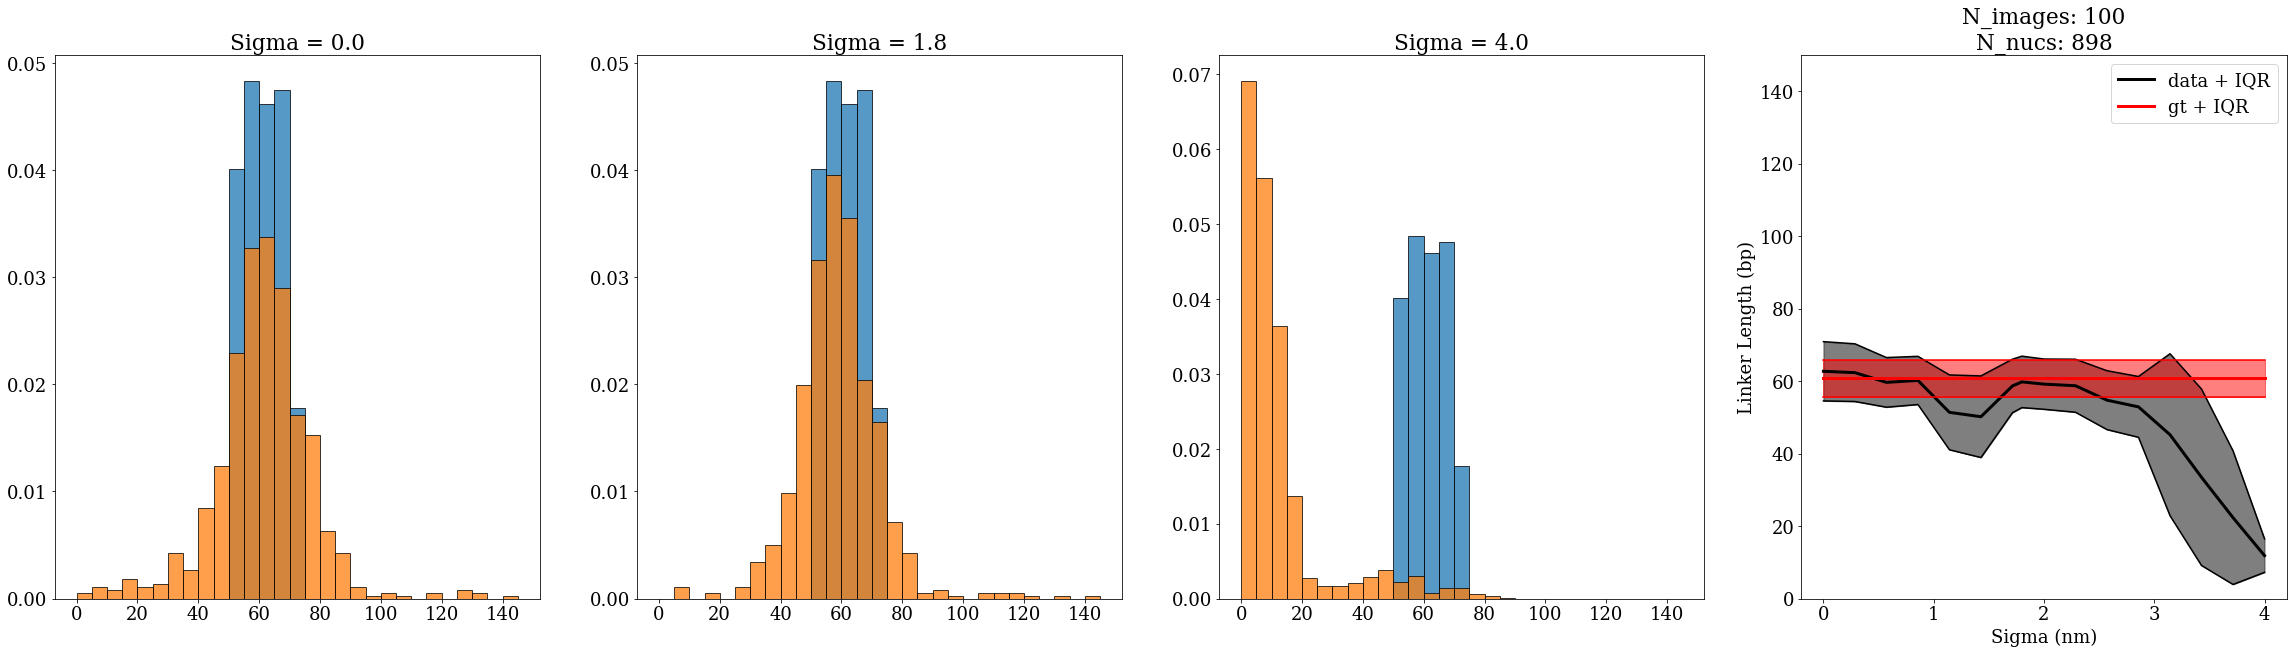

In [84]:
plt.figure(figsize=(40,10))
font = {'family' : 'serif',
    'weight':'normal',
    'size': 18}
plt.rc('font', **font)

plotidx = 1
for s in [0,7,15]:

    plt.subplot(1,4,plotidx)
    plotidx+=1
    plt.hist(links_M,density=True,edgecolor='k',alpha=0.75,label='GT Linker Lengths',bins=np.arange(0,150,5))
    plt.hist(np.array(distances_df[s])[~np.isnan(distances_df[s])],density=True,edgecolor='k',alpha=0.75,label='0.0 Noise Linker Lengths',bins=np.arange(0,150,5))
    # plt.xlim([30,100])
    plt.title('Sigma = ' + str(noise_vec[s]))
    
    
M_tot = 100

N_tot = np.sum(N_pairs[:,0:M_tot],axis=1).astype(int)

alg_means = np.zeros(len(noise_vec))
alg_std = np.zeros(len(noise_vec))

for s in range(len(noise_vec)):
    alg_means[s] = np.mean(np.array(distances_df[s][0:N_tot[s]])[~np.isnan(distances_df[s][0:N_tot[s]])])
    alg_std[s] = 0.5*iqr(np.array(distances_df[s][0:N_tot[s]])[~np.isnan(distances_df[s][0:N_tot[s]])])

gt_mean = np.ones(len(noise_vec))*np.mean(np.array(distances_df['gt_reduced'])[~np.isnan(distances_df['gt_reduced'])])
gt_std = np.ones(len(noise_vec))*0.5*iqr(np.array(distances_df['gt_reduced'])[~np.isnan(distances_df['gt_reduced'])])

plt.subplot(1,4,plotidx)
plt.plot(noise_vec,alg_means,'k-',linewidth=3, label='data + IQR')

plt.plot(noise_vec,alg_means-alg_std,'k-')
plt.plot(noise_vec,alg_means+alg_std,'k-')
plt.fill_between(noise_vec,alg_means-alg_std,
                 alg_means+alg_std,color='k',alpha=0.5)

plt.plot(noise_vec,gt_mean,'r-',linewidth=3,label =  'gt + IQR')

plt.plot(noise_vec,gt_mean-gt_std,'r-')
plt.plot(noise_vec,gt_mean+gt_std,'r-')
plt.fill_between(noise_vec,gt_mean-gt_std,
                 gt_mean+gt_std,color='r',alpha=0.5)


plt.ylim([0,150])
plt.legend()
plt.title('N_images: '+str(M_tot)+'\n'+'N_nucs: '+str(int(np.mean(N_tot))))
plt.xlabel('Sigma (nm)')
plt.ylabel('Linker Length (bp)')

plt.draw()
plt.savefig(figure_path + r"30_"+str(s)+r"_validation_dist.pdf", transparent=True)
plt.show()

In [85]:
method = 'uniform'

M = 100

packed_link = 90
packed_sig = 20

half_wrap = 73

num_pts = 101
window = 100

thresh = 0.5

noise_vec = np.sort(np.append(np.linspace(0.0,4.0,15),sig_real*0.1))
nuc_ratio = nuc_height/dna_height

L = 1999

location = np.arange(0,L,1)
signal = 0*location
accessible_starts = np.array([location[0]])
accessible_ends = np.array([location[-1]])
Gene_end = L

cdf = gene_conf.create_cdf(location,signal)

img_3d = np.zeros([M,num_pts,num_pts,num_pts])
img_nucs = np.zeros([M,num_pts,num_pts,num_pts])

img_3d_noise = np.zeros([len(noise_vec),M,num_pts,num_pts,num_pts])
img_3d_closed = np.zeros([len(noise_vec),M,num_pts,num_pts,num_pts])
img_3d_binary = np.zeros([len(noise_vec),M,num_pts,num_pts,num_pts])

links_M = []
links_trim = []

for m in range(M):
    
    if method == 'poisson':
        nucs = gene_conf.sample_cdf_poisson(location,signal,cdf,accessible_starts,
                                                    accessible_ends,half_wrap,packed_link)
    if method == 'uniform':
        nucs = gene_conf.sample_cdf_uniform(location,signal,cdf,accessible_starts,
                                                    accessible_ends,half_wrap,packed_link,packed_sig)

    links = gene_conf.create_links_sample(location,signal,nucs,half_wrap)
    links_M = np.append(links_M,links)
    links_trim = np.append(links_trim,links[1:-1])

    r, rdna1, rdna2, rn, un = wlcstat.chromo.gen_chromo_conf(links.astype(int),w_ins=half_wrap-1,w_outs=half_wrap)
    r = r[3*half_wrap:-3*half_wrap,0:]

    rmean = np.mean(r,axis=0)

    coordinates_x = np.linspace(rmean[0]-0.5*window,rmean[0]+0.5*window,num_pts)
    coordinates_y = np.linspace(rmean[1]-0.5*window,rmean[1]+0.5*window,num_pts)
    coordinates_z = np.linspace(rmean[2]-0.5*window,rmean[2]+0.5*window,num_pts)

    delta_voxel = np.mean(np.diff(coordinates_z))


    for i in range(len(r)):
        if ((r[i,0] >= coordinates_x[0] and r[i,0] <= coordinates_x[-1]) and (r[i,1] >= coordinates_y[0] and r[i,1] <= coordinates_y[-1]) and (r[i,2] >= coordinates_z[0] and r[i,2] <= coordinates_z[-1])):
            img_3d[m,np.argmin(np.abs(r[i,0]-coordinates_x)),np.argmin(np.abs(r[i,1]-coordinates_y)),np.argmin(np.abs(r[i,2]-coordinates_z))] = 1#np.random.beta(5,2,1)

    img_3d[m,:,:,:] = ndimage.binary_dilation(img_3d[m,:,:,:],ball(np.round(2*1.25/delta_voxel)/2))


    for i in range(len(rn)):
        if ((rn[i,0] >= coordinates_x[0] and rn[i,0] <= coordinates_x[-1]) and (rn[i,1] >= coordinates_y[0] and rn[i,1] <= coordinates_y[-1]) and (rn[i,2] >= coordinates_z[0] and rn[i,2] <= coordinates_z[-1])):
            img_nucs[m,np.argmin(np.abs(rn[i,0]-coordinates_x)),np.argmin(np.abs(rn[i,1]-coordinates_y)),np.argmin(np.abs(rn[i,2]-coordinates_z))] = 1

    img_nucs[m,:,:,:] = ndimage.binary_dilation(img_nucs[m,:,:,:],ball(np.round(2*2.25/delta_voxel)/2))

    
    for s in range(len(noise_vec)):
    
        img_3d_noise[s,m,:,:,:] =  np.random.poisson((255*(ndimage.gaussian_filter(img_3d[m,:,:,:]+nuc_ratio*img_nucs[m,:,:,:],sigma=noise_vec[s]))).astype(int))/255
        img_3d_noise[s,m,:,:,:] = (img_3d_noise[s,m,:,:,:]-np.min(img_3d_noise[s,m,:,:,:]))/(np.max(img_3d_noise[s,m,:,:,:])-np.min(img_3d_noise[s,m,:,:,:]))

        img_3d_binary[s,m,:,:,:] = 1.0*(img_3d_noise[s,m,:,:,:]>thresh)

        for i in range(num_pts):
            for j in range(num_pts):
                for k in range(num_pts):
                    if img_3d_binary[s,m,i,j,k]!=1:
                        img_3d_closed[s,m,i,j,k] = img_3d_noise[s,m,i,j,k]

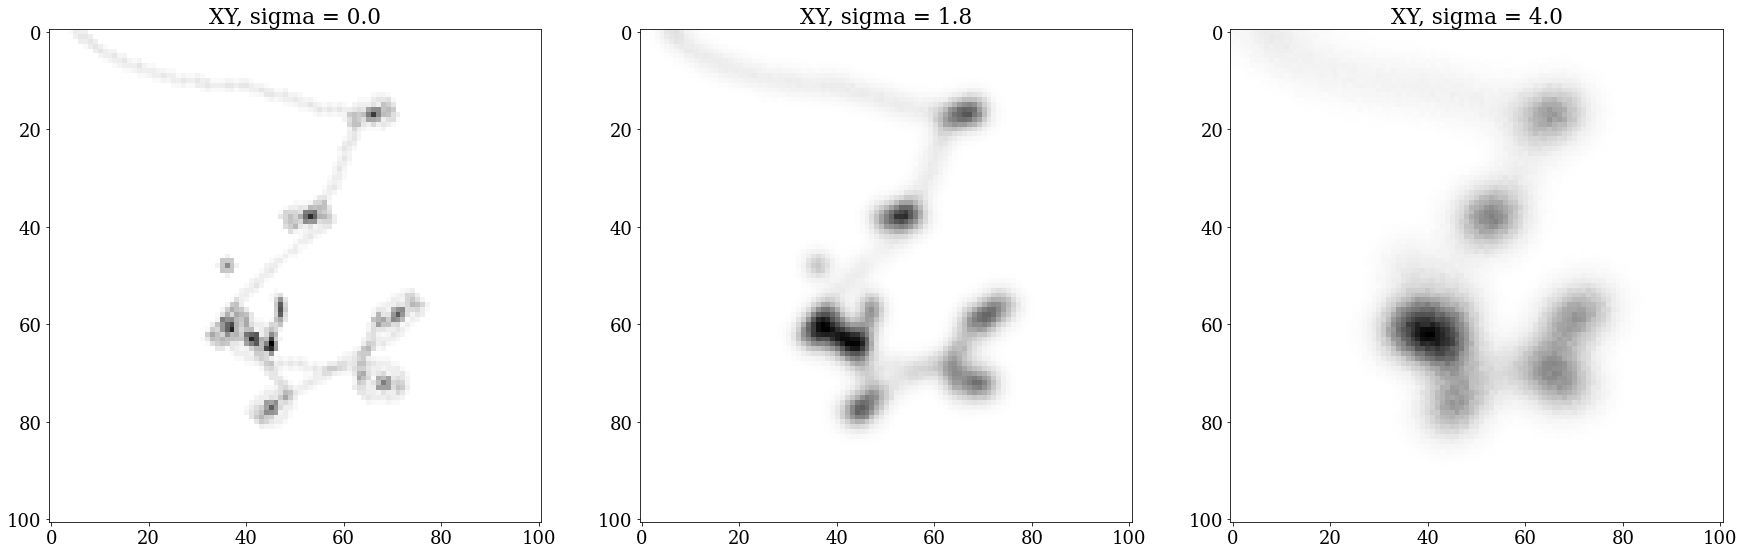

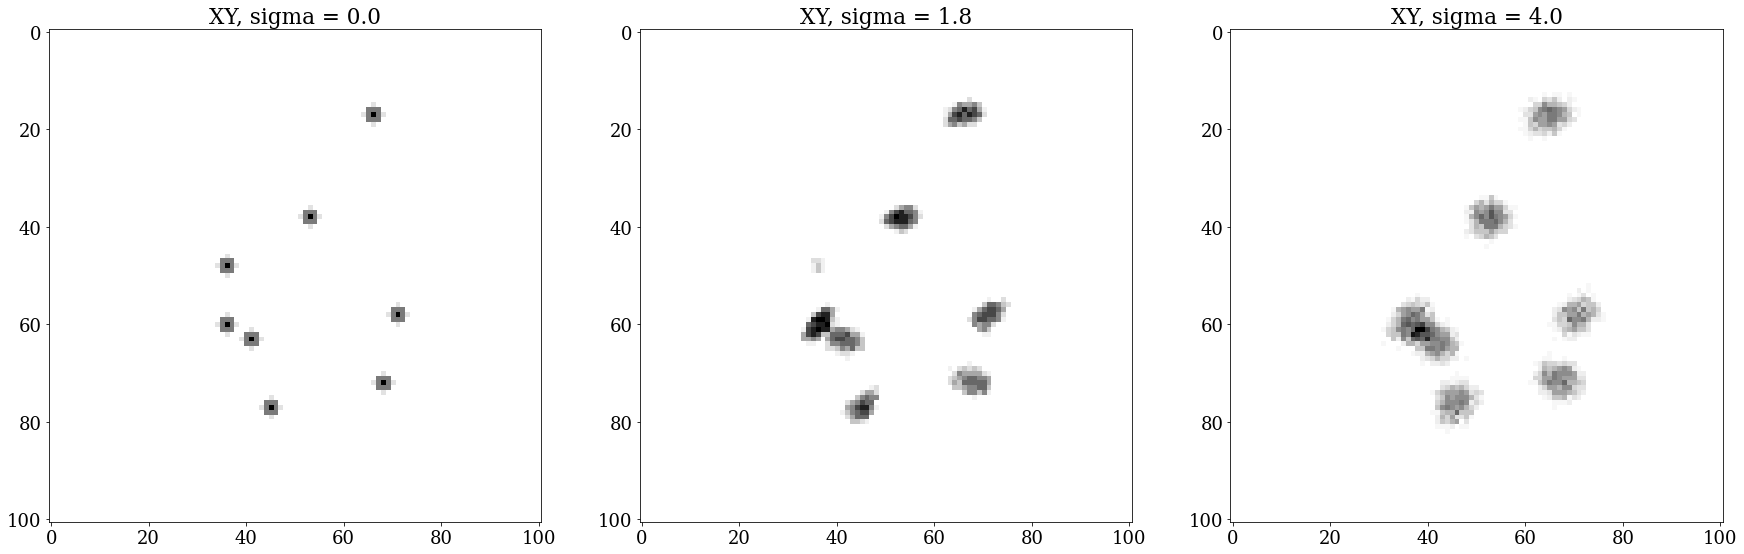

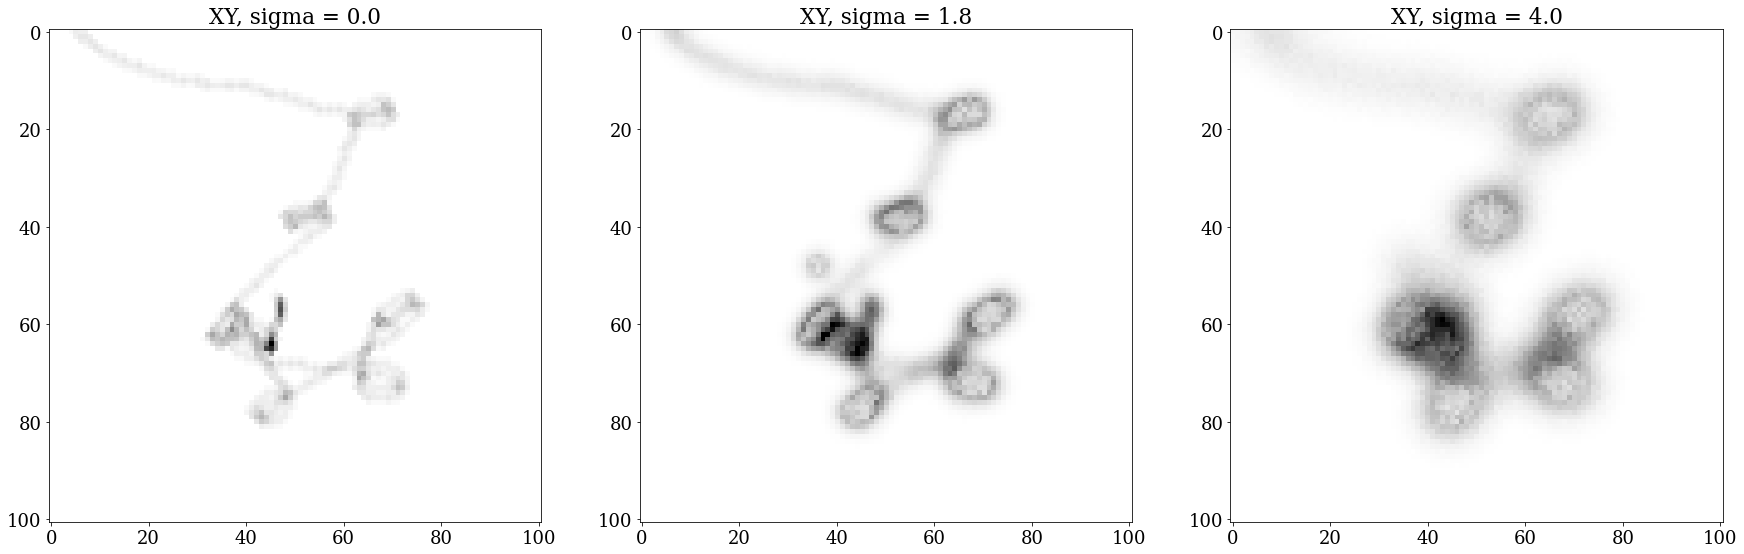

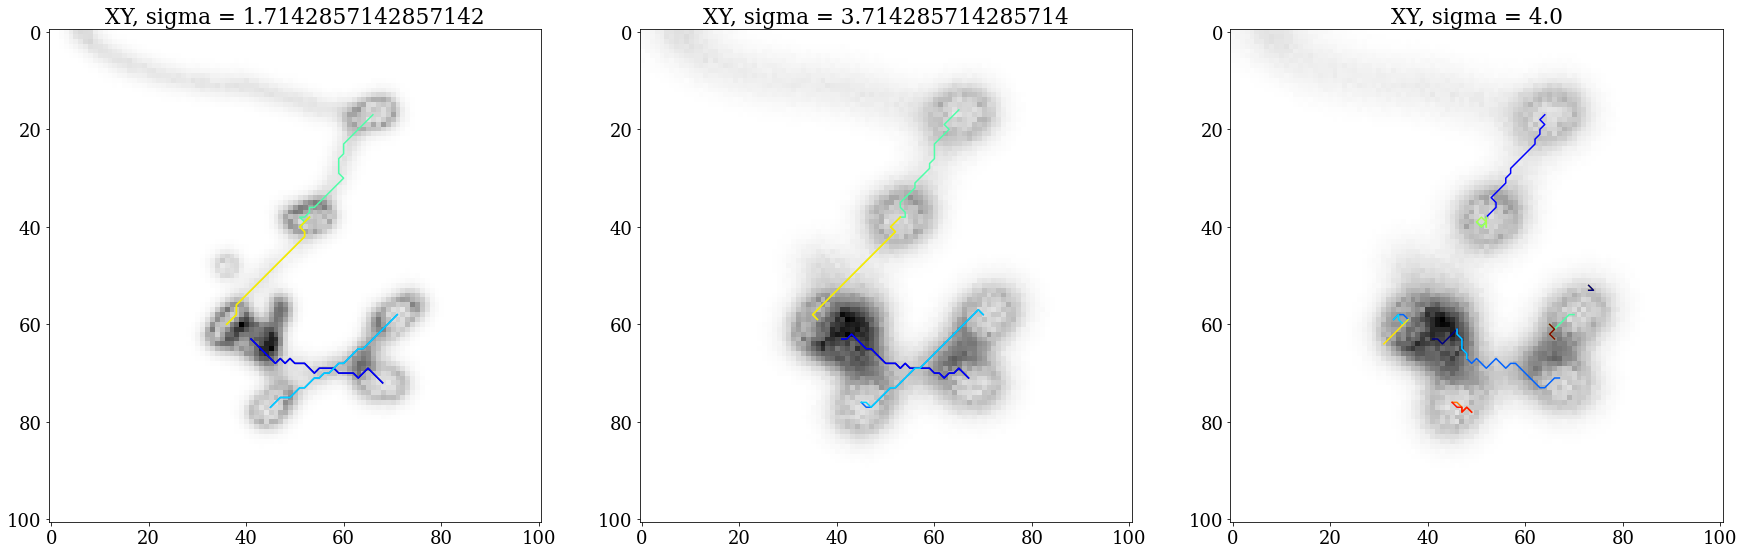

In [86]:
m = 0

plt.figure(figsize=(30,10))
font = {'family' : 'serif',
    'weight':'normal',
    'size': 18}
plt.rc('font', **font)

idx = 1
for s in [0,7,15]:
    plt.subplot(1,3,int(idx))
    idx+=1
    temp = np.sum(img_3d_noise[s,m,:,:,:],axis=0).T
    # temp[temp > 0] = 1
    # temp = temp+1
    plt.imshow(temp,cmap='Greys',  interpolation='nearest')
    plt.title('XY, sigma = '+str(noise_vec[s]))

    
plt.draw()
plt.savefig(figure_path + r"30_synth_em_raw.pdf", transparent=True)
    
plt.show()

plt.figure(figsize=(30,10))
font = {'family' : 'serif',
    'weight':'normal',
    'size': 18}
plt.rc('font', **font)

idx = 1
for s in [0,7,15]:
    plt.subplot(1,3,int(idx))
    idx+=1
    temp = np.sum(img_3d_binary[s,m,:,:,:],axis=0).T
    # temp[temp > 0] = 1
    # temp = temp+1
    plt.imshow(temp,cmap='Greys',  interpolation='nearest')
    plt.title('XY, sigma = '+str(noise_vec[s]))

plt.draw()
plt.savefig(figure_path + r"30_synth_em_nucs.pdf", transparent=True)
    
plt.show()

plt.figure(figsize=(30,10))
font = {'family' : 'serif',
    'weight':'normal',
    'size': 18}
plt.rc('font', **font)

idx = 1
for s in [0,7,15]:
    plt.subplot(1,3,int(idx))
    idx+=1
    temp = np.sum(img_3d_closed[s,m,:,:,:],axis=0).T
    # temp[temp > 0] = 1
    # temp = temp+1
    plt.imshow(temp,cmap='Greys',  interpolation='nearest')
    plt.title('XY, sigma = '+str(noise_vec[s]))
    

plt.draw()
plt.savefig(figure_path + r"30_synth_em_cost.pdf", transparent=True)

plt.show()

plt.figure(figsize=(30,10))
font = {'family' : 'serif',
    'weight':'normal',
    'size': 18}
plt.rc('font', **font)

cmap = plt.cm.get_cmap('jet', 10)

distances_dict = {'gt_reduced': links_trim,'gt' : links_M}
pairs_dict = {}

N_pairs = np.zeros([len(noise_vec),M])

plotidx = 0
for s in range(len(noise_vec)):
    distances_all = []
    pairs_all = []
    
    cx = 0
    if (s==0 or s==7 or s==15):
        plotidx+= 1
    plt.subplot(1,3,plotidx)
    temp = np.sum(img_3d_closed[s,0,:,:,:],axis=0).T
    plt.imshow(temp,cmap='Greys',  interpolation='nearest')
    plt.title('XY, sigma = '+str(noise_vec[s]))
    
    
    for m in range(M):

        output_img, N = cc3d.connected_components(img_3d_binary[s,m,:,:,:], return_N=True)

        stats = cc3d.statistics(output_img)
        centers = stats['centroids']

        costs = 1-img_3d_closed[s,m,:,:,:]

        distances = []
        pairs = []

        for ix in range(1,N):
            minD = 400
            pair = (np.zeros(3),np.zeros(3))
            visited = False
            if stats['voxel_counts'][ix] <= 1000:
                idx = np.array([centers[ix,0].astype(int),centers[ix,1].astype(int),centers[ix,2].astype(int)])
                for jx in range(1,N):
                    if stats['voxel_counts'][jx] <= 1000:
                        if jx != ix:
                            jdx = np.array([centers[jx,0].astype(int),centers[jx,1].astype(int),centers[jx,2].astype(int)])
                            if (np.linalg.norm(idx-jdx) < minD):
                                boolval = True
                                for k in range(len(pairs)):
                                    if (np.linalg.norm(pairs[k][0]-idx)*
                                        np.linalg.norm(pairs[k][1]-jdx)<=1e-3) or (np.linalg.norm(pairs[k][1]-idx)*
                                                                                   np.linalg.norm(pairs[k][0]-jdx)<=1e-3):
                                        boolval = False
                                if boolval:

                                    path = dijkstra3d.dijkstra(costs, idx, jdx)

                                    if len(path) > 0:

                                        cost_temp = 0
                                        for px in range(len(path)-2):
                                            cost_temp += np.linalg.norm(np.array(path[px+1]).astype(int)-np.array(path[px]).astype(int))*delta_voxel/0.34
                                        cost = cost_temp


                                    if cost < minD:
                                        visited = True
                                        minD = cost
                                        pair = (idx,jdx)
            if visited and (minD >= delta_voxel):
                minD = minD
                distances.append(np.max([minD-11,0]))
                
                if m == 0 and (s==0 or s==7 or s==15):
                
                    path = dijkstra3d.dijkstra(costs, pair[0], pair[1])
                    temp_path = np.zeros([3,len(path)])

                    for i in range(len(path)):
                        temp_path[0][i] = path[i][0]
                        temp_path[1][i] = path[i][1]
                        temp_path[2][i] = path[i][2]

                    plt.subplot(1,3,plotidx)

                    plt.plot(temp_path[1],temp_path[2],'-',color=cmap(cx))

                    cx += 1
                    if cx > 9:
                        cx = 0


        distances_all = np.append(distances_all,distances)
        pairs_all = np.append(pairs_all,pairs)
        N_pairs[s,m] = len(distances)
        
    distances_dict[s] = distances_all
    pairs_dict[s] = pairs_all

distances_df = pd.DataFrame({ key:pd.Series(value) for key, value in distances_dict.items() })
pairs_df = pd.DataFrame({ key:pd.Series(value) for key, value in pairs_dict.items() })

plt.draw()
plt.savefig(figure_path + r"30_synth_em_paths.pdf", transparent=True)

plt.show()

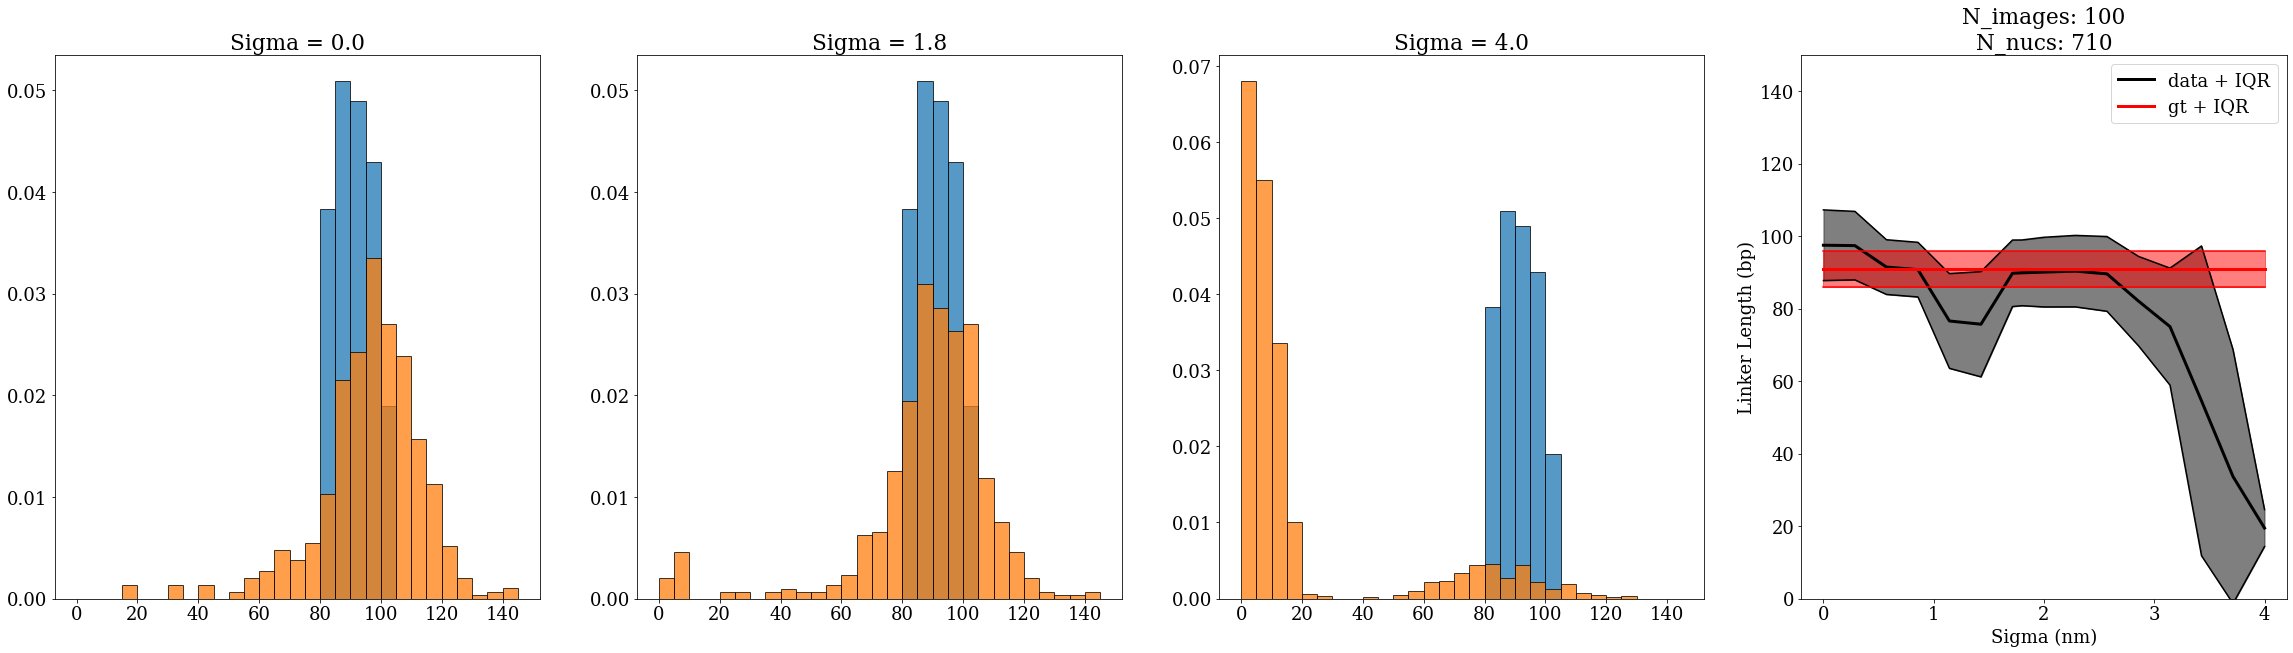

In [87]:
plt.figure(figsize=(40,10))
font = {'family' : 'serif',
    'weight':'normal',
    'size': 18}
plt.rc('font', **font)

plotidx = 1
for s in [0,7,15]:

    plt.subplot(1,4,plotidx)
    plotidx+=1
    plt.hist(links_M,density=True,edgecolor='k',alpha=0.75,label='GT Linker Lengths',bins=np.arange(0,150,5))
    plt.hist(np.array(distances_df[s])[~np.isnan(distances_df[s])],density=True,edgecolor='k',alpha=0.75,label='0.0 Noise Linker Lengths',bins=np.arange(0,150,5))
    # plt.xlim([30,100])
    plt.title('Sigma = ' + str(noise_vec[s]))
    
    
M_tot = 100

N_tot = np.sum(N_pairs[:,0:M_tot],axis=1).astype(int)

alg_means = np.zeros(len(noise_vec))
alg_std = np.zeros(len(noise_vec))

for s in range(len(noise_vec)):
    alg_means[s] = np.mean(np.array(distances_df[s][0:N_tot[s]])[~np.isnan(distances_df[s][0:N_tot[s]])])
    alg_std[s] = 0.5*iqr(np.array(distances_df[s][0:N_tot[s]])[~np.isnan(distances_df[s][0:N_tot[s]])])

gt_mean = np.ones(len(noise_vec))*np.mean(np.array(distances_df['gt_reduced'])[~np.isnan(distances_df['gt_reduced'])])
gt_std = np.ones(len(noise_vec))*0.5*iqr(np.array(distances_df['gt_reduced'])[~np.isnan(distances_df['gt_reduced'])])

plt.subplot(1,4,plotidx)
plt.plot(noise_vec,alg_means,'k-',linewidth=3, label='data + IQR')

plt.plot(noise_vec,alg_means-alg_std,'k-')
plt.plot(noise_vec,alg_means+alg_std,'k-')
plt.fill_between(noise_vec,alg_means-alg_std,
                 alg_means+alg_std,color='k',alpha=0.5)

plt.plot(noise_vec,gt_mean,'r-',linewidth=3,label =  'gt + IQR')

plt.plot(noise_vec,gt_mean-gt_std,'r-')
plt.plot(noise_vec,gt_mean+gt_std,'r-')
plt.fill_between(noise_vec,gt_mean-gt_std,
                 gt_mean+gt_std,color='r',alpha=0.5)


plt.ylim([0,150])
plt.legend()
plt.title('N_images: '+str(M_tot)+'\n'+'N_nucs: '+str(int(np.mean(N_tot))))
plt.xlabel('Sigma (nm)')
plt.ylabel('Linker Length (bp)')

plt.draw()
plt.savefig(figure_path + r"30_"+str(s)+r"_validation_dist.pdf", transparent=True)
plt.show()

# Fractal Analysis

In [88]:
packed_link = 43

half_wrap = 73

L = 100000


location = np.arange(0,L-1,1)
signal = 0*location
accessible_starts = np.array([location[0]])
accessible_ends = np.array([location[-1]])
Gene_end = L-1


cdf = gene_conf.create_cdf(location,signal)

M = 10000

r_dist = np.zeros((len(cdf)-2,M))

for m in range(M):
    nucs = gene_conf.sample_cdf_poisson(location,signal,cdf,accessible_starts,
                                            accessible_ends,half_wrap,packed_link)

    links = gene_conf.create_links_sample(location,signal,nucs,half_wrap)


    r, rdna1, rdna2, rn, un = wlcstat.chromo.gen_chromo_conf(links.astype(int),w_ins=half_wrap-1,w_outs=half_wrap)
    r = r[3*half_wrap:-3*half_wrap,0:]
    
    r_dist[:,m] = np.linalg.norm(r[1:] - r[0], axis=1)

1.0019901941449134
2.8191969786686033
2.031105052583656


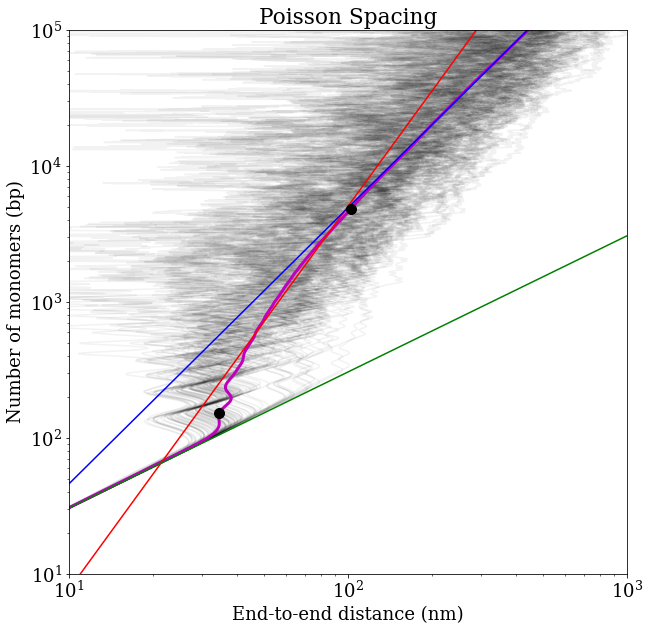

In [92]:
L = 100000

x = np.log10(np.mean(r_dist,axis=1))
y = np.log10(np.arange(1,L-2))

H = np.argmin(np.abs(x-np.log10(5)))
I = np.argmin(np.abs(10**y-150.6024096385542))
J = np.argmin(np.abs(10**x-102.4))
# I = J-2500
K = np.argmin(np.abs(y-np.log10(10000)))

slope_left,intercept_left = np.polyfit(x[:H],y[:H],1)

print(slope_left)


slope_mid,intercept_mid = np.polyfit(x[I:J],y[I:J],1)

print(slope_mid)


slope_right,intercept_right = np.polyfit(x[K:],y[K:],1)

print(slope_right)

plt.figure(figsize=(10,10))
font = {'family' : 'serif',
    'weight':'normal',
    'size': 18}
plt.rc('font', **font)

for m in range(0,M,100):
    plt.plot(r_dist[:,m],np.arange(1,len(r)),'k-',alpha=0.05)
plt.plot(np.mean(r_dist,axis=1),np.arange(1,len(r)),'m-',linewidth=3)
# plt.plot(10**x,10**(slope_left*x + intercept_left),'b--')

plt.plot(10**x,10**(slope_mid*x + intercept_mid),'r-')
plt.plot(10**(2*x),10**(slope_left*(2*x) + intercept_left),'g-')
plt.plot(10**x,10**(slope_right*x + intercept_right),'b-')
plt.plot(10**x[I],10**y[I],'k.',markersize=20)
plt.plot(10**x[J],10**y[J],'k.',markersize=20)


# plt.plot(10**x,10**(slope_right*x + intercept_right),'r--')
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e1,1e5])
plt.xlim([1e1,1e3])
plt.xlabel('End-to-end distance (nm)')
plt.ylabel('Number of monomers (bp)')
plt.title('Poisson Spacing')
plt.draw()
plt.savefig(figure_path + r"fractal_polymer_poisson.pdf", transparent=True)
plt.show()

In [90]:
len(r)

99998